In [ ]:
# this notebook has results up to 89% in models section

## I&I

In [1]:
import os,sys
ROOT_DIR = os.path.abspath("../")
sys.path.append(ROOT_DIR)  # To find local version of the library

In [2]:
ROOT_DIR

'/home/gidi/nbs/RoadTrackACC'

In [3]:
# imports
import pandas as pd
import numpy as np
import glob
from collections import Counter
from datetime import datetime
from matplotlib import pyplot as plt
import seaborn as sb
import datetime
import itertools

from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import confusion_matrix as cm

% matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# add auto relaod
%load_ext autoreload
% autoreload 2
from utils import *
from detect_peaks import detect_peaks
    
from sklearn_porter import Porter

In [4]:
cd ..

/home/gidi/nbs/RoadTrackACC


In [5]:
key_df = pd.read_csv("/home/gidi/nbs/RoadTrackACC/annotations/RoadTrack_Experiment_log - Acc_Data.csv")
data_folder = '/home/gidi/nbs/RoadTrackACC/data/'

In [6]:
tow_files = key_df[key_df.event_type=='Tow'].file_name.unique()
standstill_files = key_df[key_df.event_type=='Standstill'].file_name.unique()

In [7]:
tow_files=tow_files[1:]

In [8]:
# load the sheets from following files - relevant to towing

loader =DataLoader()
loader.load_data([data_folder+file for file in np.unique(np.append(tow_files,standstill_files))],plot=True)
big_df = loader.big_df

TypeError: __init__() missing 1 required positional argument: 'dest'

In [9]:
# Load all files error in bumpers file
f=glob.glob('data/*.xlsx')
e = DataLoader('bumper')
e.load_data(f)
big_df=e.big_df

Loading file:data/Acc_Data_0805.xlsx
Acc_Data_0805.xlsx Regular
Acc_Data_0805.xlsx Bumper1
Acc_Data_0805.xlsx Bumper2
Acc_Data_0805.xlsx Zigzag1
Acc_Data_0805.xlsx Zigzag2
Acc_Data_0805.xlsx Zigzag3
Loading file:data/Acc_Data_060618.xlsx
Acc_Data_060618.xlsx BackHit1
Acc_Data_060618.xlsx BackHit2
Acc_Data_060618.xlsx FrontHit1
Acc_Data_060618.xlsx FrontHit2
Loading file:data/Acc_Data_Tow_1605.xlsx
Acc_Data_Tow_1605.xlsx Tow_Chevrolet1
Acc_Data_Tow_1605.xlsx Tow_Chevrolet2
Acc_Data_Tow_1605.xlsx Tow_Chevrolet3
Acc_Data_Tow_1605.xlsx Tow_Chevrolet1_Back
Acc_Data_Tow_1605.xlsx Tow_Chevrolet2_Back
Acc_Data_Tow_1605.xlsx Tow_Chevrolet3_Back
Acc_Data_Tow_1605.xlsx Tow_Nissan1
Acc_Data_Tow_1605.xlsx Tow_Nissan2
Acc_Data_Tow_1605.xlsx Tow_Nissan3
Acc_Data_Tow_1605.xlsx Tow_Nissan1_Back
Acc_Data_Tow_1605.xlsx Tow_Nissan2_Back
Acc_Data_Tow_1605.xlsx Tow_Nissan3_Back
Acc_Data_Tow_1605.xlsx Tow_Toyota1
Acc_Data_Tow_1605.xlsx Tow_Toyota2
Acc_Data_Tow_1605.xlsx Tow_Toyota3
Acc_Data_Tow_1605.xlsx Tow

In [102]:
len(big_df)

290983

## Annotation file(s)

### Vizualize towing

In [81]:
# read annotation file
event = 'tow' # 'bumper'

anot_file = 'annotations/Roadtrack_tags - Acc_Data_240418.csv'

anot = pd.read_csv(anot_file)
    

events = anot[anot.event==event]
# fit date time format. first workout hard stops
events['start time']=pd.to_datetime(events['start time'])
events['end time']=pd.to_datetime(events['end time'])
anot.keys()

Index(['file', 'sheet', 'event', 'start time', 'end time', 'start row',
       'end row', 'date'],
      dtype='object')

In [ ]:
events

In [84]:
# set towing annotations annotations - variant 1
big_df['tow_on']=0

big_df['tow_on'][(big_df.cat_id==6)&(big_df.time_sec >= events['start time']) &(big_df.time_sec <= events['end time'])]=1

ValueError: Can only compare identically-labeled Series objects

In [87]:
# variant 2

big_df['tow_on']=0

for row in events.iterrows():
    # very slow :(( sometimes
    tow_time = row[1]
    #dfa_times = self.research_dfa.index.to_datetime()
    big_df['tow_on'][(big_df.file==row[1]['file'])&(big_df.time_sec > tow_time['start time']) &(big_df.time_sec < tow_time['end time']) & (big_df.cat_id == 6)] = 1
    print(len(big_df['tow_on'][(big_df.file==row[1]['file'])&(big_df.time_sec > tow_time['start time']) &(big_df.time_sec < tow_time['end time']) & (big_df.cat_id == 6)]))
    print(row[1]['file'], row[1]['start time'],row[1]['end time'])
sum(big_df.tow_on)    

0
Acc_Data_Tow_1005 2018-06-12 09:17:46 2018-06-12 09:20:59
0
Acc_Data_Tow_1005 2018-06-12 09:23:30 2018-06-12 09:26:20
0
Acc_Data_Tow_1005 2018-06-12 09:28:11 2018-06-12 09:30:55
0
Acc_Data_Tow_1005 2018-06-12 09:37:24 2018-06-12 09:40:15
0
Acc_Data_Tow_1005 2018-06-12 09:42:17 2018-06-12 09:45:05
0
Acc_Data_Tow_1005 2018-06-12 09:46:36 2018-06-12 09:49:23
0
Acc_Data_Tow_1005 2018-06-12 09:53:46 2018-06-12 09:56:20
0
Acc_Data_Tow_1005 2018-06-12 09:57:39 2018-06-12 10:00:19
0
Acc_Data_Tow_1005 2018-06-12 10:01:51 2018-06-12 10:04:34
0
Acc_Data_Tow_1005 2018-06-12 10:07:28 2018-06-12 10:10:14
0
Acc_Data_Tow_1005 2018-06-12 10:11:47 2018-06-12 10:14:36
0
Acc_Data_Tow_1005 2018-06-12 10:15:57 2018-06-12 10:18:43
0
Acc_Data_Tow_1005 2018-06-12 10:25:32 2018-06-12 10:28:20
0
Acc_Data_Tow_1005 2018-06-12 10:29:35 2018-06-12 10:32:19
0
Acc_Data_Tow_1005 2018-06-12 10:33:53 2018-06-12 10:36:36
0
Acc_Data_Tow_1005 2018-06-12 10:40:03 2018-06-12 10:43:07
0
Acc_Data_Tow_1005 2018-06-12 10:44:55 

1502

In [88]:
sum(big_df.tow_on)

1502

In [90]:
len(big_df)

290983

26814 Acc_Data_070618.xlsx Tow1_March


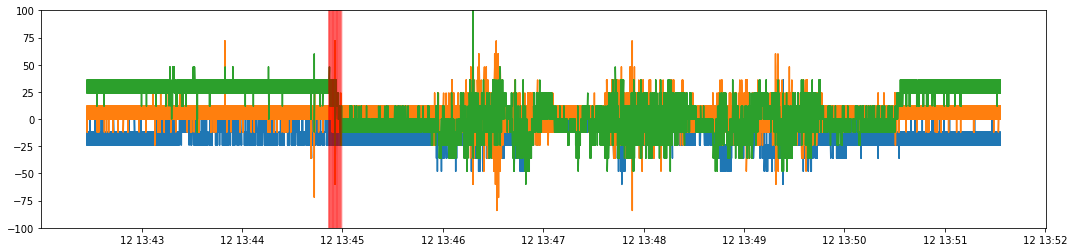

25221 Acc_Data_070618.xlsx Tow2_March


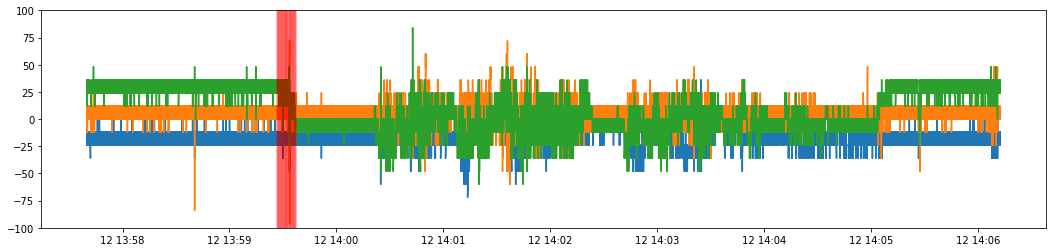

22572 Acc_Data_070618.xlsx Tow2_Tiida


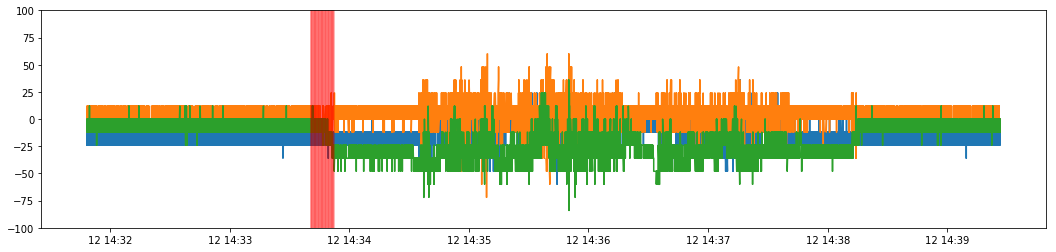

10972 Acc_Data_Tow_1005.xlsx Tow_Chevrolet1


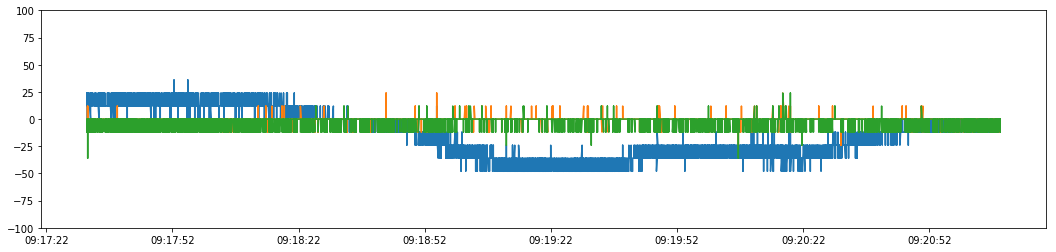

11315 Acc_Data_Tow_1005.xlsx Tow_Chevrolet2


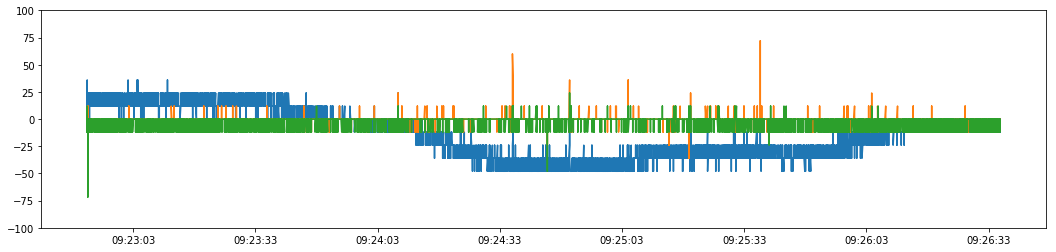

9312 Acc_Data_Tow_1005.xlsx Tow_Chevrolet3


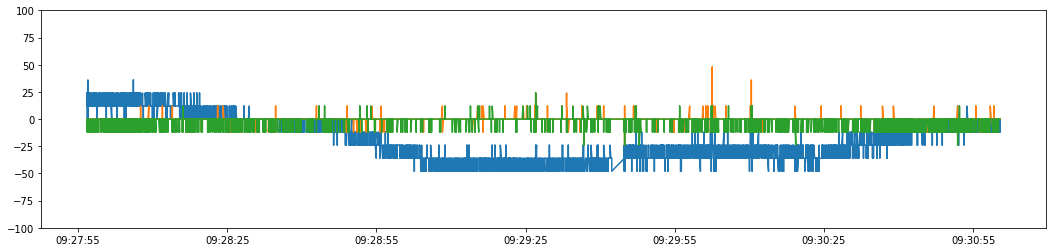

9260 Acc_Data_Tow_1005.xlsx Tow_Chevrolet1_Back


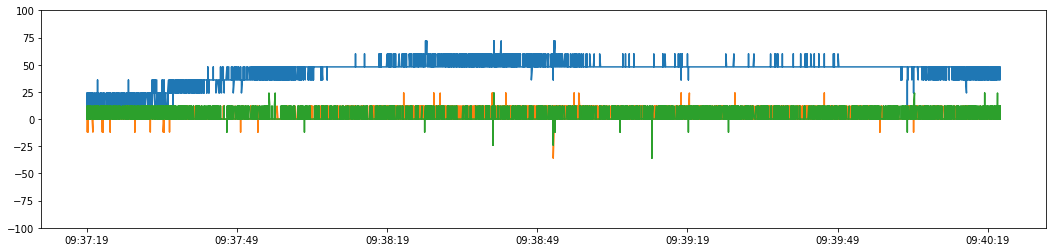

9532 Acc_Data_Tow_1005.xlsx Tow_Chevrolet2_Back


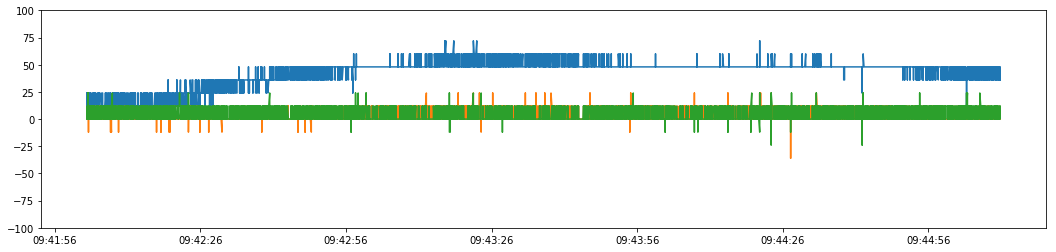

9509 Acc_Data_Tow_1005.xlsx Tow_Chevrolet3_Back


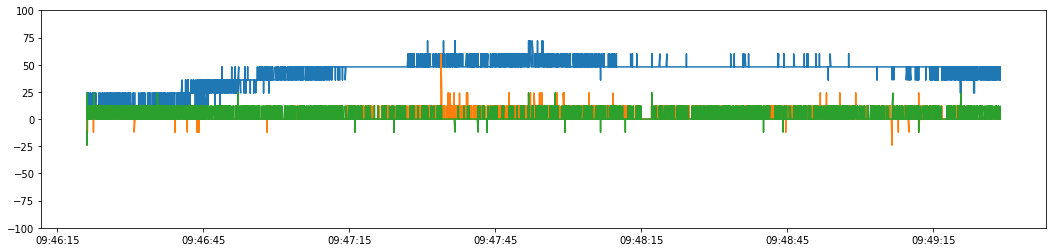

8899 Acc_Data_Tow_1005.xlsx Tow_Nissan1


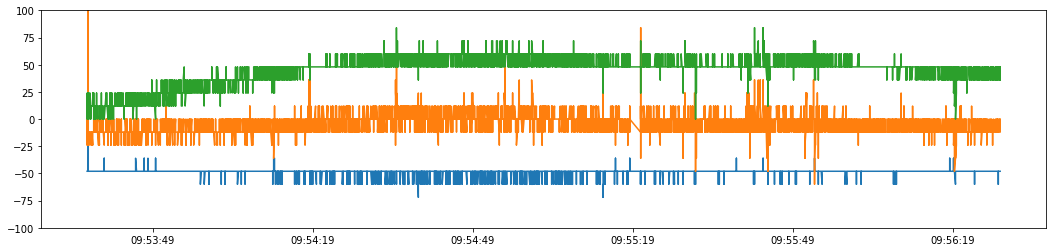

9446 Acc_Data_Tow_1005.xlsx Tow_Nissan2


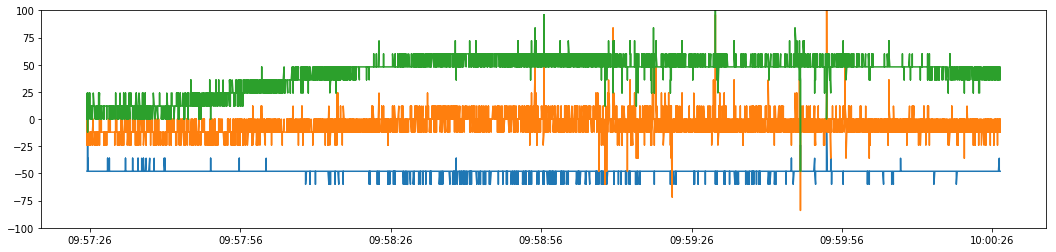

9669 Acc_Data_Tow_1005.xlsx Tow_Nissan3


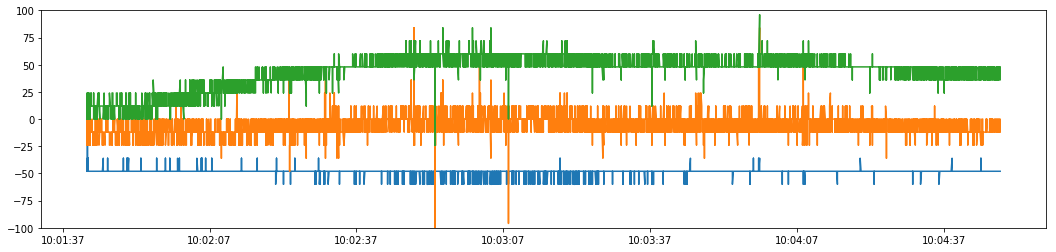

9456 Acc_Data_Tow_1005.xlsx Tow_Nissan1_Back


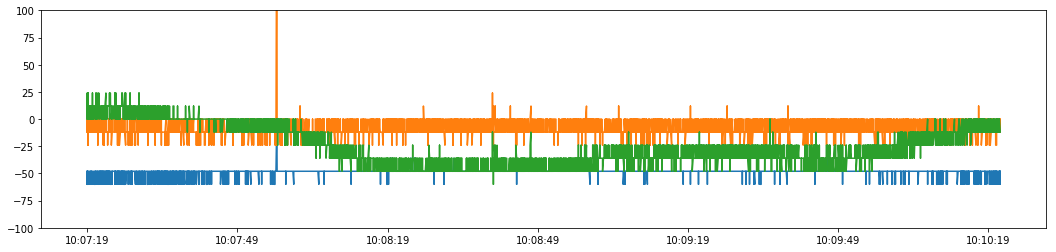

9867 Acc_Data_Tow_1005.xlsx Tow_Nissan2_Back


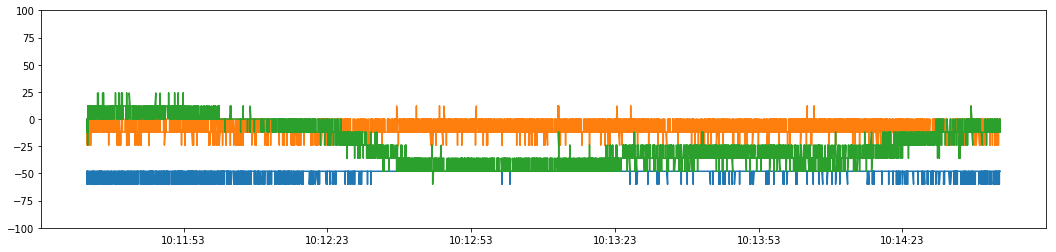

9337 Acc_Data_Tow_1005.xlsx Tow_Nissan3_Back


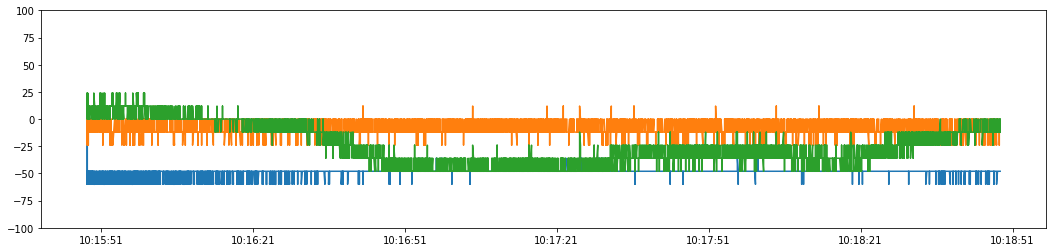

9916 Acc_Data_Tow_1005.xlsx Tow_Toyota1


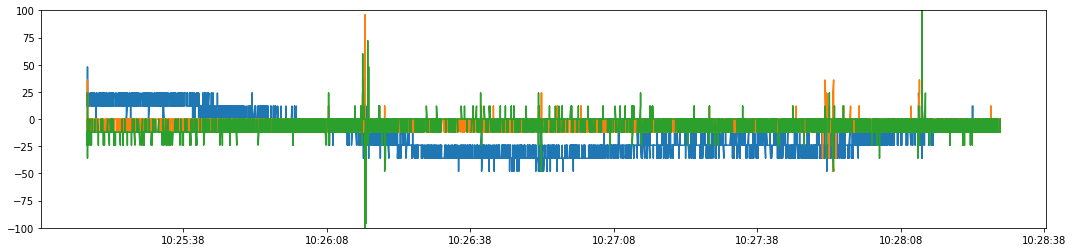

9751 Acc_Data_Tow_1005.xlsx Tow_Toyota2


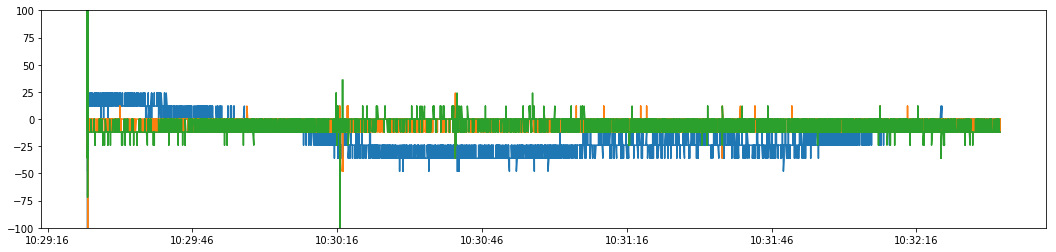

9217 Acc_Data_Tow_1005.xlsx Tow_Toyota3


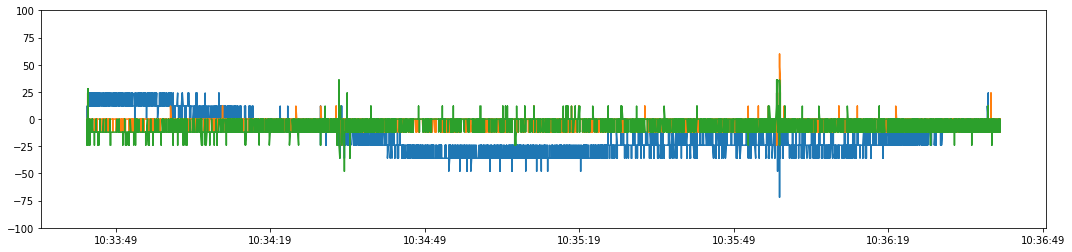

10585 Acc_Data_Tow_1005.xlsx Tow_Toyota1_Back


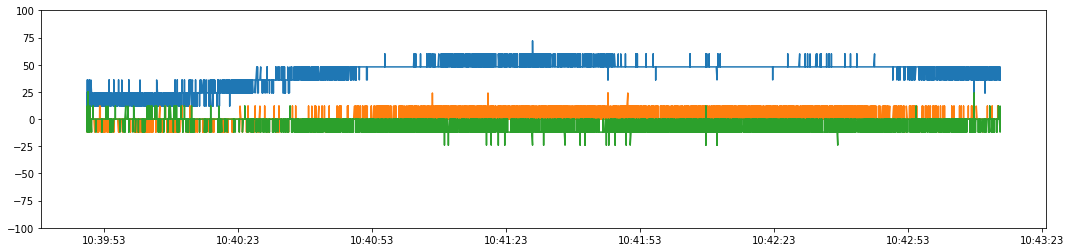

10031 Acc_Data_Tow_1005.xlsx Tow_Toyota2_Back


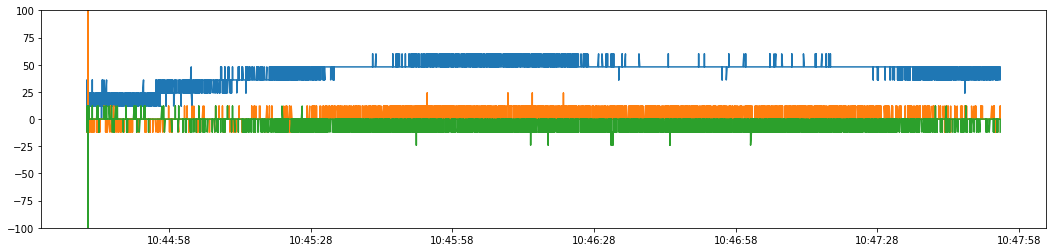

10202 Acc_Data_Tow_1005.xlsx Tow_Toyota3_Back


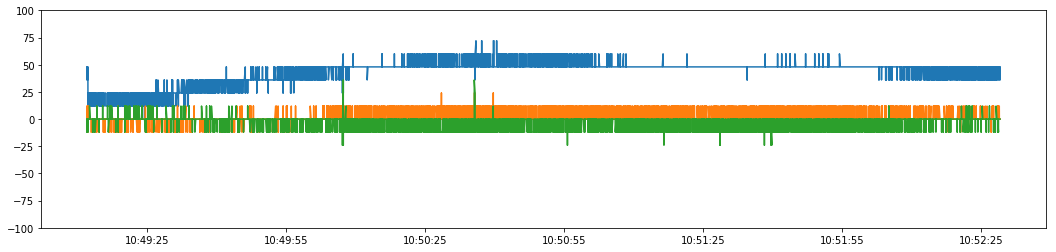

757 Acc_Data_Tow_1605.xlsx Tow_Chevrolet1


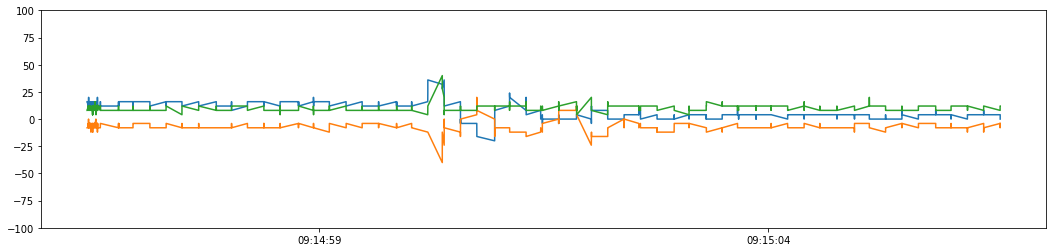

793 Acc_Data_Tow_1605.xlsx Tow_Chevrolet2


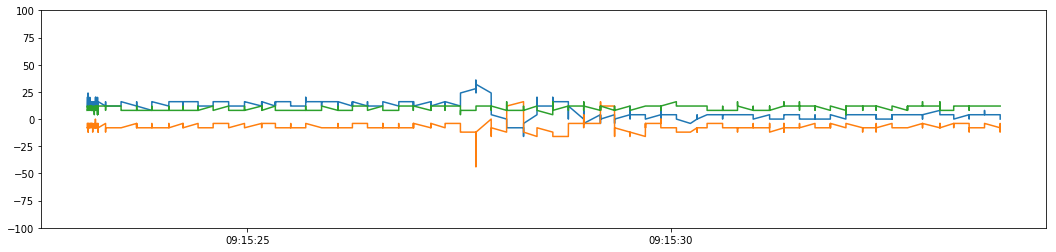

844 Acc_Data_Tow_1605.xlsx Tow_Chevrolet3


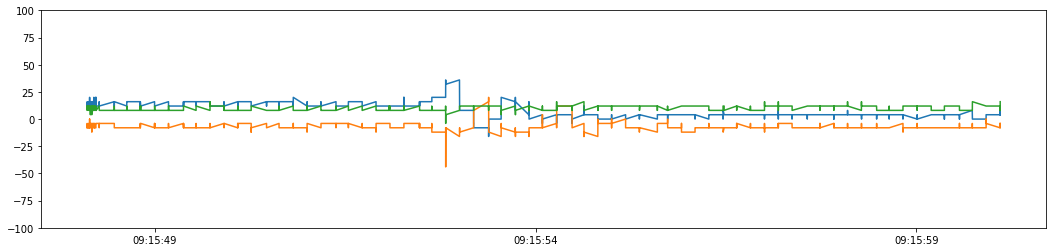

836 Acc_Data_Tow_1605.xlsx Tow_Chevrolet1_Back


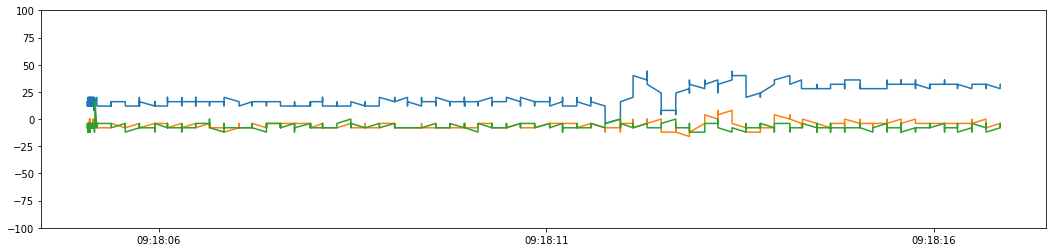

891 Acc_Data_Tow_1605.xlsx Tow_Chevrolet2_Back


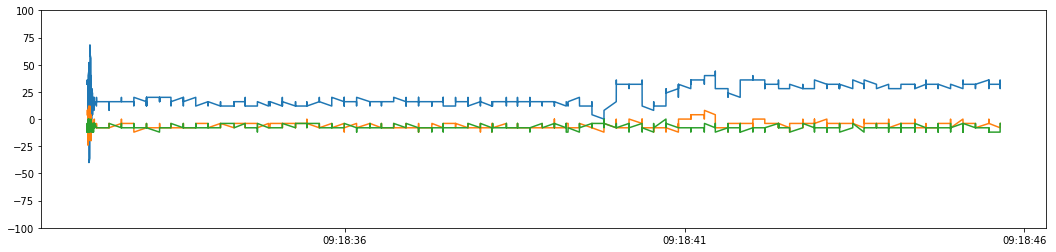

891 Acc_Data_Tow_1605.xlsx Tow_Chevrolet3_Back


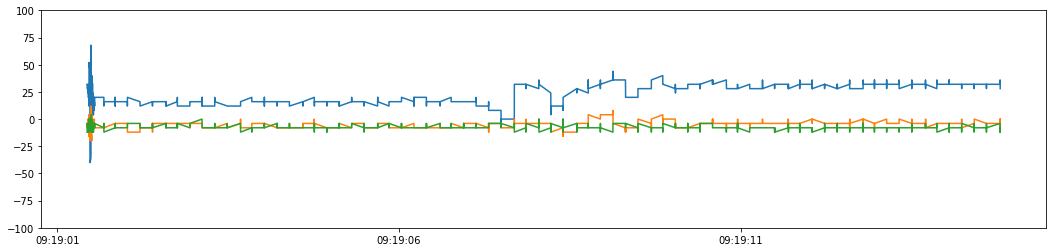

836 Acc_Data_Tow_1605.xlsx Tow_Nissan1


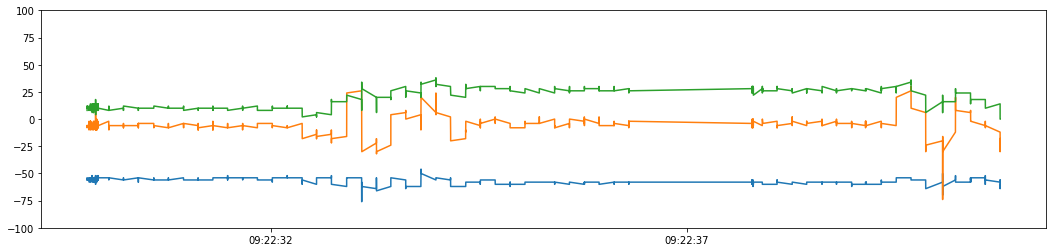

1028 Acc_Data_Tow_1605.xlsx Tow_Nissan2


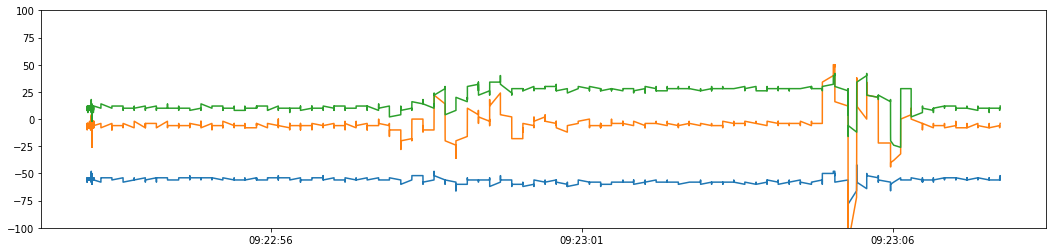

910 Acc_Data_Tow_1605.xlsx Tow_Nissan3


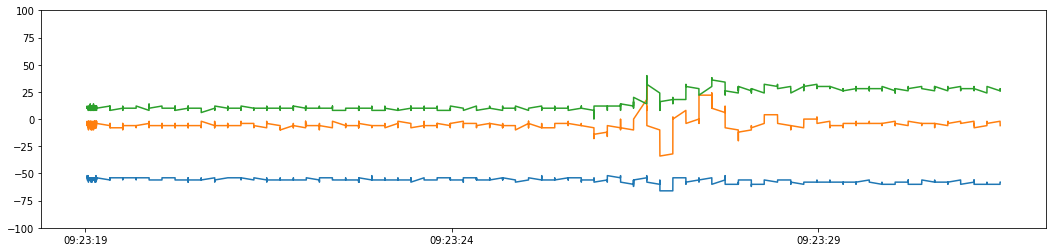

945 Acc_Data_Tow_1605.xlsx Tow_Nissan1_Back


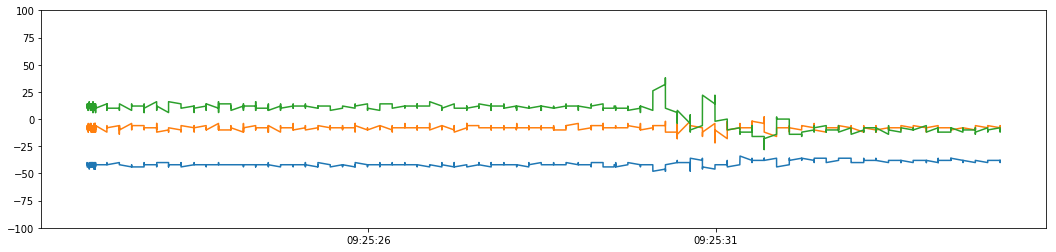

909 Acc_Data_Tow_1605.xlsx Tow_Nissan2_Back


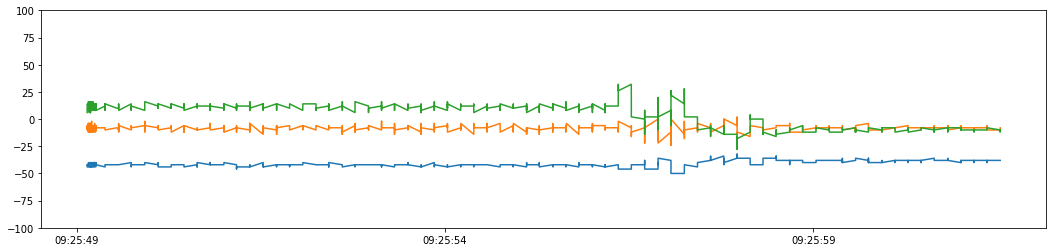

927 Acc_Data_Tow_1605.xlsx Tow_Nissan3_Back


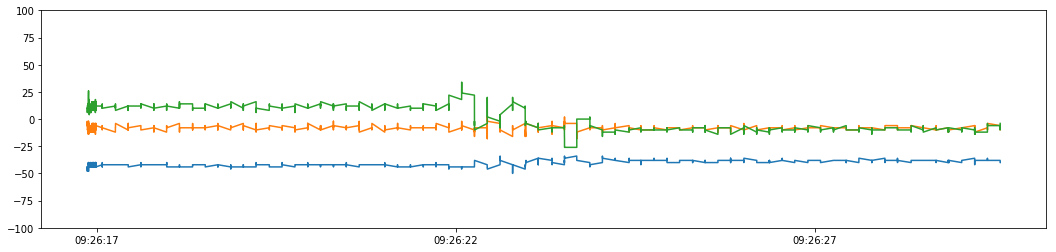

762 Acc_Data_Tow_1605.xlsx Tow_Toyota1


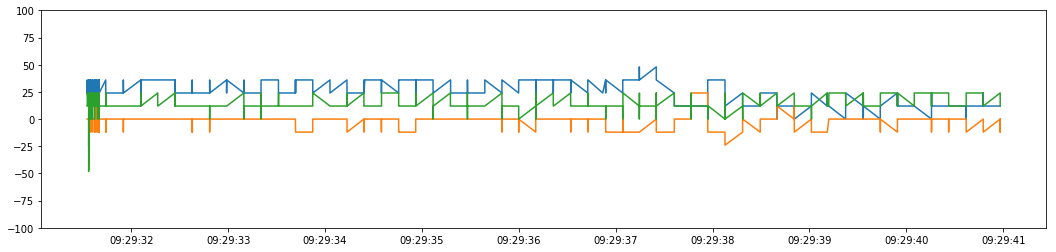

792 Acc_Data_Tow_1605.xlsx Tow_Toyota2


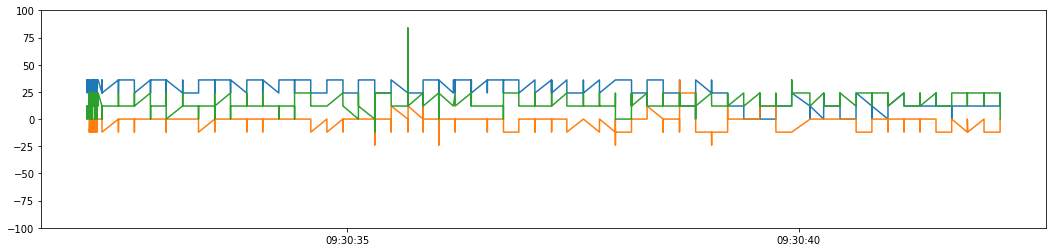

855 Acc_Data_Tow_1605.xlsx Tow_Toyota3


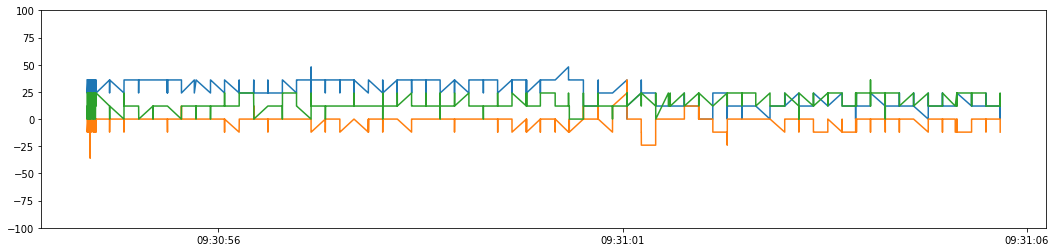

816 Acc_Data_Tow_1605.xlsx Tow_Toyota1_Back


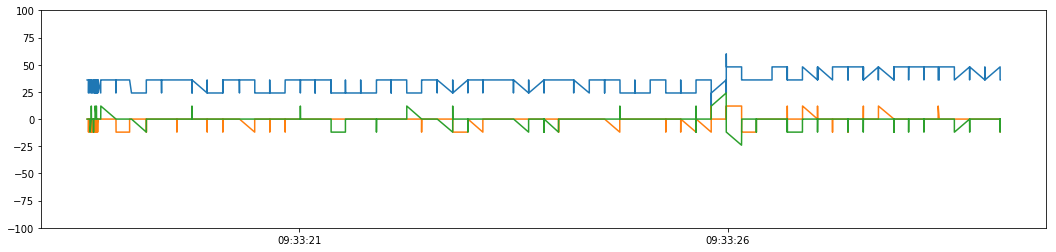

784 Acc_Data_Tow_1605.xlsx Tow_Toyota2_Back


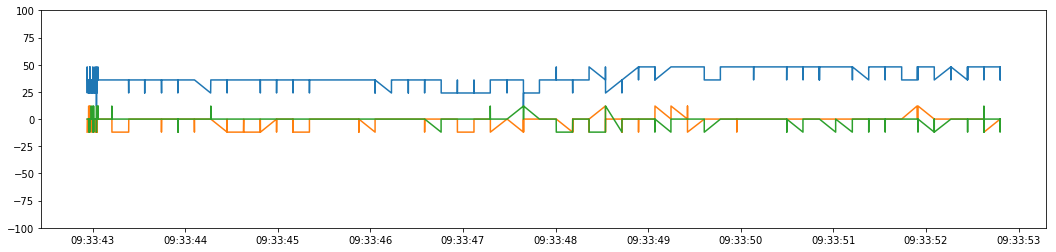

765 Acc_Data_Tow_1605.xlsx Tow_Toyota3_Back


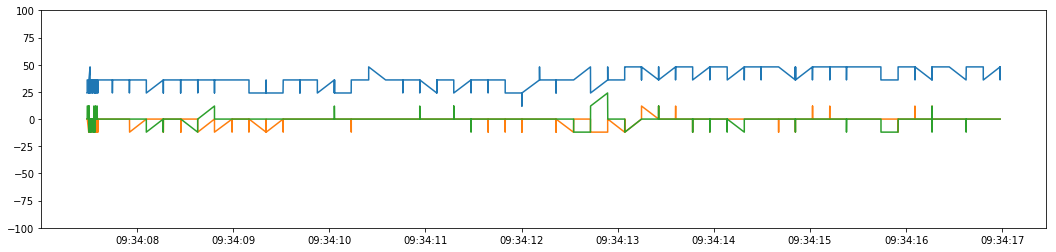

In [89]:
# tow. plot

for r in big_df[big_df['cat_id'].isin([6])][['sheet','file']].drop_duplicates().iterrows():
    sheet=r[1]['sheet']
    file=r[1]['file']

    fig,ax = plt.subplots(figsize=(18,4))
    df = big_df[(big_df['cat_id'].isin([6]))&(big_df.sheet==sheet)&(big_df.file==file)]
    #break
    print(len(df),file,sheet)
    ax.set_ylim(-100,100)
    ax.plot(df.index, df['Forward'])
    ax.plot(df.index, df['Vertical'])
    ax.plot(df.index, df['Radial'])
    #ax.set_title(sheet+' '+df['file'].iloc[0])
    for i,tow in enumerate(df.tow_on[df.tow_on==1].iteritems()):
        ax.axvline(x=tow[0], color='r',alpha=0.02)

    #f = thresholding_algo(df.Vertical,400,10,0.7)
    #fig,ax = plt.subplots(figsize=(18,4))
    #ax.plot(f['signals'])
    plt.show()

### annotation parsing and bumpers + Vizualisation

In [10]:
# read annotation file
event = 'bumper' # 'bumper'

anot_file = 'annotations/Roadtrack_tags - Acc_Data_240418.csv'

anot = pd.read_csv(anot_file)
    

events = anot[anot.event==event]
# fit date time format. first workout hard stops
events['start time']=pd.to_datetime(events['start time'])
events['end time']=pd.to_datetime(events['end time'])
anot.keys()

Index(['file', 'sheet', 'event', 'start time', 'end time', 'start row',
       'end row', 'date'],
      dtype='object')

In [11]:
#offset bumpers
events.loc[events.file.isin(['Acc_Data_0205.xlsx','Acc_Data_0305.xlsx']),'start time']=\
events.loc[events.file.isin(['Acc_Data_0205.xlsx','Acc_Data_0305.xlsx']),'start time']+ pd.DateOffset(seconds=10)

In [12]:
# make a list of bumpers

# up to 3.5 - ~?
# up to 3.8 - ~ 154
events_list=[]
first_second_stop = []
for row in events.iterrows():
    i=0
    time = row[1]['start time']
    first_second_stop.append(time)
    #while time >= row[1]['start time'] and time<=row[1]['start time']+datetime.timedelta(0,1):
    for i in range(1,3):
        events_list.append(time)
        time=row[1]['start time']+datetime.timedelta(0,i) 
        i+=1
len(events_list)

180

In [13]:
# set bumper annotations

big_df['bumper_on']=0
big_df['cat_id'][(big_df.cat_id==40)]=4
big_df['bumper_on'][(big_df.cat_id==4)&(big_df.time_sec.isin(events_list))]=1
big_df['cat_id'][(big_df.cat_id==4)&(big_df.time_sec.isin(events_list))]=40
sum(big_df['bumper_on']),sum(big_df[big_df['cat_id']==40]['bumper_on'])
# <8.5 = 7960

(8904, 8904)

757 Acc_Data_Tow_1605.xlsx Tow_Chevrolet1


AttributeError: 'DataFrame' object has no attribute 'tow_on'

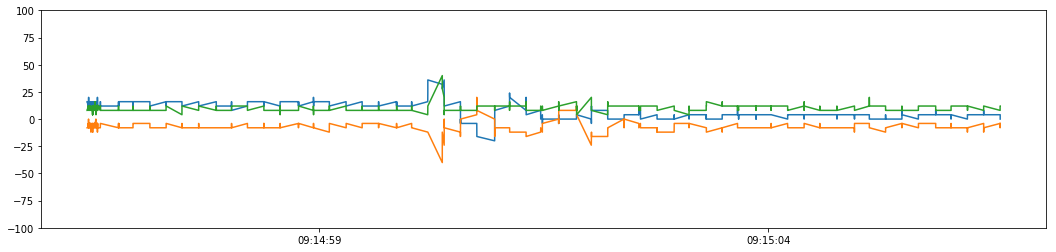

In [14]:
# tow. plot

for r in big_df[big_df['cat_id'].isin([6])][['sheet','file']].drop_duplicates().iterrows():
    sheet=r[1]['sheet']
    file=r[1]['file']

    fig,ax = plt.subplots(figsize=(18,4))
    df = big_df[(big_df['cat_id'].isin([6]))&(big_df.sheet==sheet)&(big_df.file==file)]
    #break
    print(len(df),file,sheet)
    ax.set_ylim(-100,100)
    ax.plot(df.index, df['Forward'])
    ax.plot(df.index, df['Vertical'])
    ax.plot(df.index, df['Radial'])
    #ax.set_title(sheet+' '+df['file'].iloc[0])
    for i,tow in enumerate(df.tow_on[df.tow_on==1].iteritems()):
        ax.axvline(x=tow[0], color='r',alpha=0.02)

    #f = thresholding_algo(df.Vertical,400,10,0.7)
    #fig,ax = plt.subplots(figsize=(18,4))
    #ax.plot(f['signals'])
    plt.show()

9954


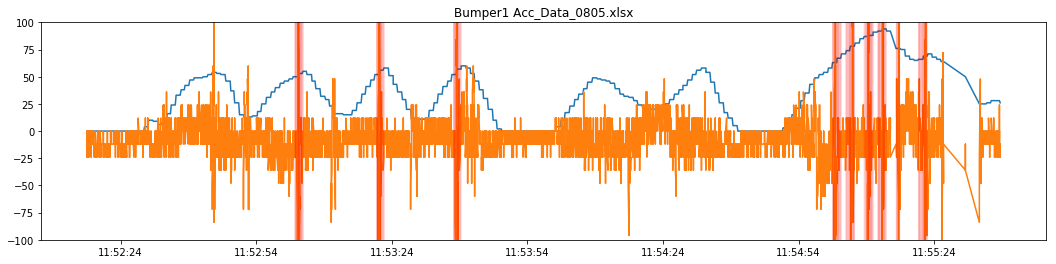

10126


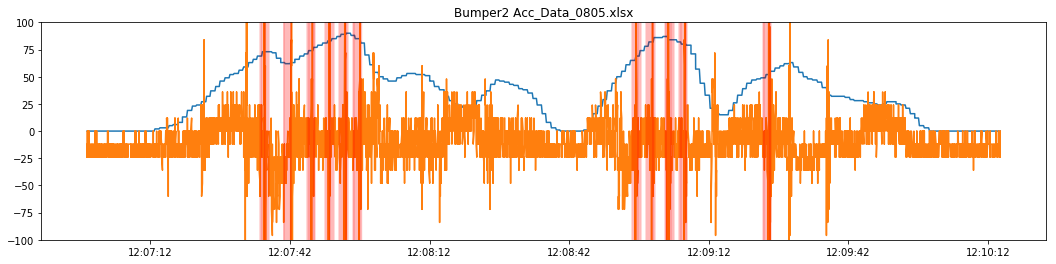

18222


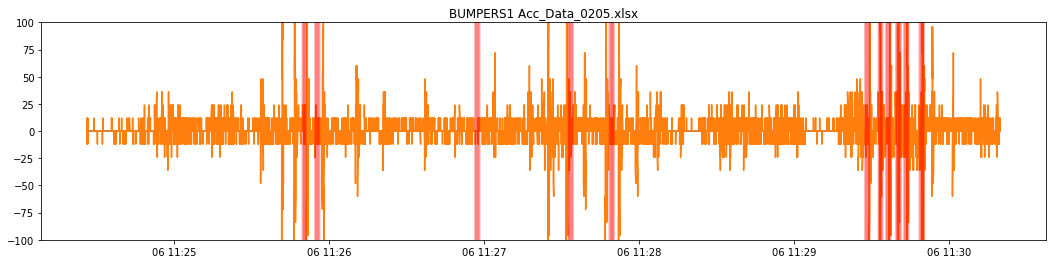

13795


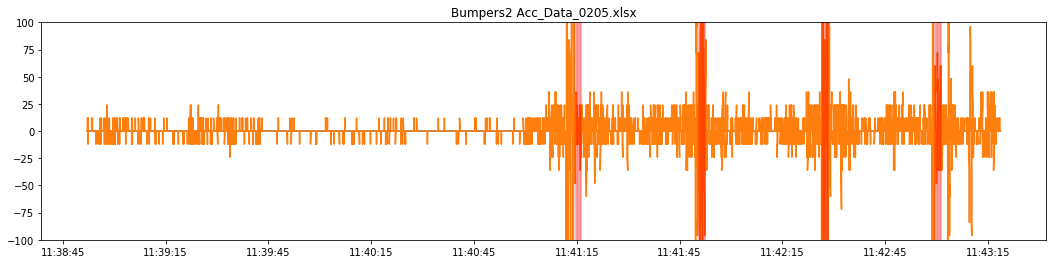

6638


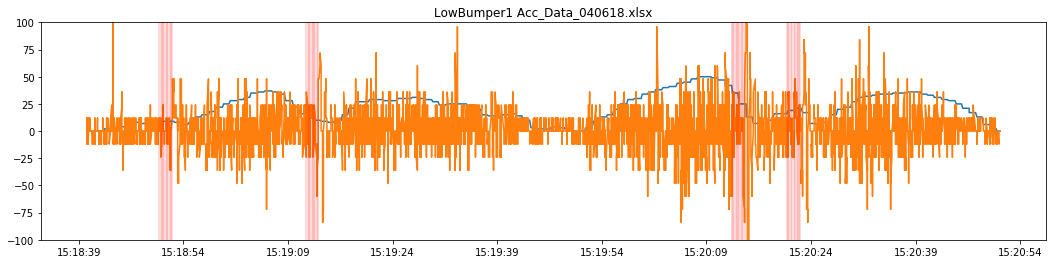

6085


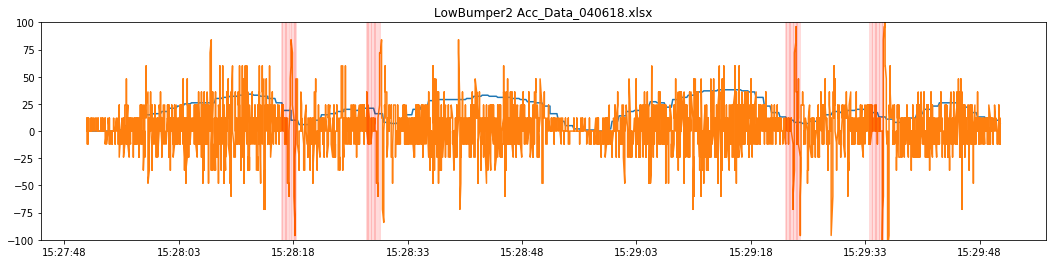

5749


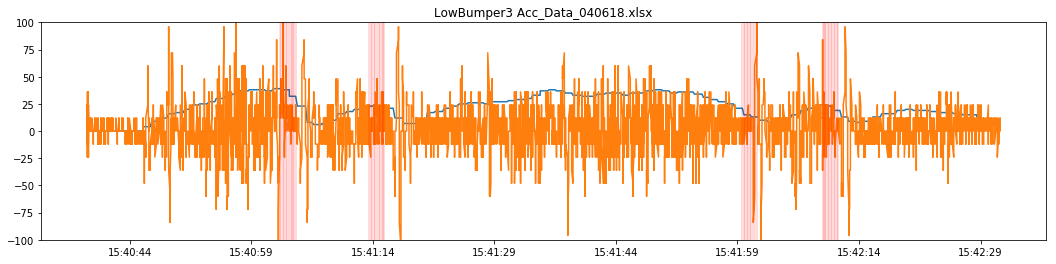

4947


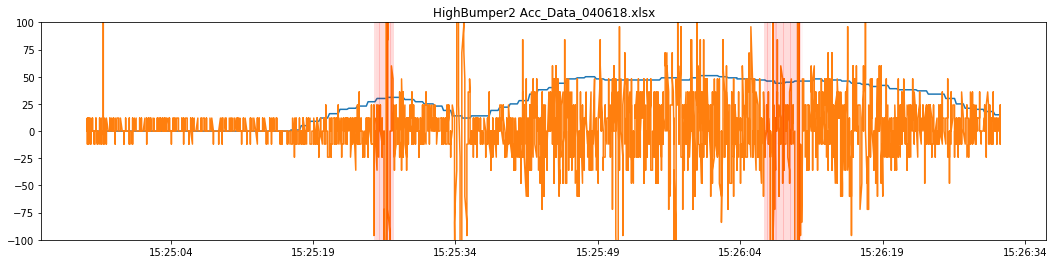

4648


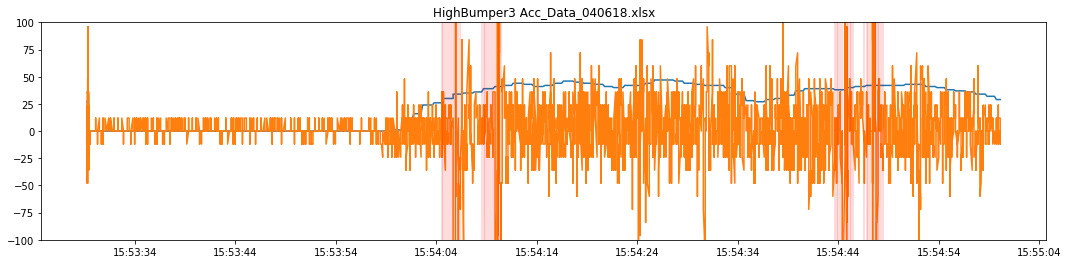

2180


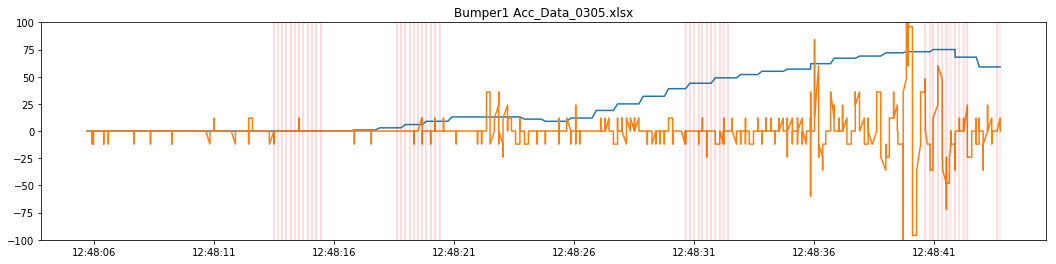

16385


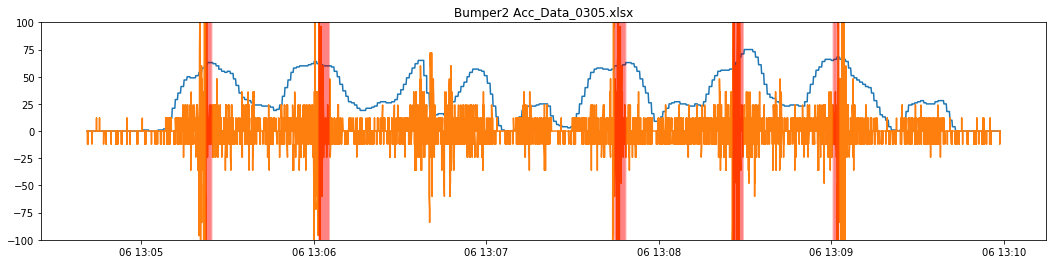

In [16]:
# bumpers. plot

for r in big_df[big_df['cat_id'].isin([4,40])][['sheet','file']].drop_duplicates().iterrows():
    sheet=r[1]['sheet']
    file=r[1]['file']
    if '2404' not in file and '2604' not in file: # removing 24 and 26 because these are small bumpers

        fig,ax = plt.subplots(figsize=(18,4))
        df = big_df[(big_df['cat_id'].isin([4,40]))&(big_df.sheet==sheet)&(big_df.file==file)]
        
        print(len(df))
        ax.set_ylim(-100,100)
        ax.plot(df.index, df['Speed'])
        ax.plot(df.index, df['Vertical'])
        ax.set_title(sheet+' '+df['file'].iloc[0])
        for i,bump in enumerate(df.bumper_on[df.bumper_on==1].iteritems()):
            ax.axvline(x=bump[0], color='r',alpha=0.02)
        
        #f = thresholding_algo(df.Vertical,400,10,0.7)
        #fig,ax = plt.subplots(figsize=(18,4))
        #ax.plot(f['signals'])
        plt.show()

### hard stops from list

In [1352]:
hard_stops = anot[anot.event=='hard_stop']
# fit date time format. first workout hard stops
hard_stops['start time']=pd.to_datetime(hard_stops['start time'])
hard_stops['end time']=pd.to_datetime(hard_stops['end time'])
anot.keys()

Index(['file', 'sheet', 'event', 'start time', 'end time', 'start row',
       'end row'],
      dtype='object')

In [1353]:
#  make a list of hard stops from annotation file

hard_stop_list=[]
first_second_stop = []
for row in hard_stops.iterrows():
    i=0
    time = row[1]['start time']
    first_second_stop.append(time)
    while time >= row[1]['start time'] and time<=row[1]['end time']:
        hard_stop_list.append(time)
        time=row[1]['start time']+datetime.timedelta(0,i) 
        i+=1

In [1354]:
# set hard stops annotations
big_df['hard_stop_on']=0
big_df['hard_stop_on']\
[(big_df['file']=='Acc_Test_240418.xlsx')&(big_df.cat_id==5)&(big_df.time_sec.isin(hard_stop_list))]=1
big_df['hard_stop_on']\
[(big_df['file']=='Acc_Test_240418.xlsx')&(big_df.cat_id==5)&(big_df.time_sec.isin(first_second_stop))]=2

### Annotate/detect emergency stop

In [62]:
hard_Stop_threshold = -7

Emergency_stop
Hard_Stop


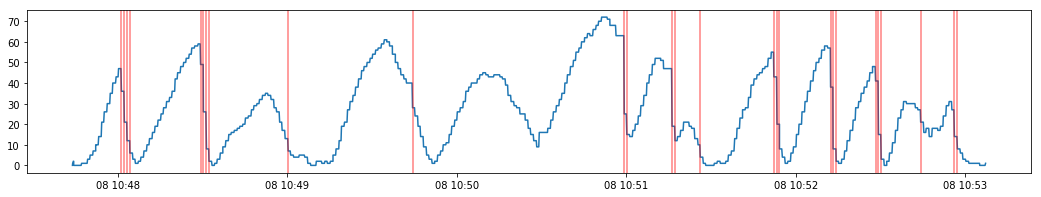

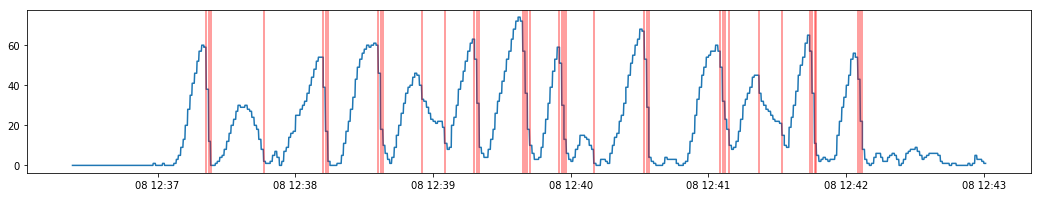

In [855]:
# emergency stops sheet speed drops

#### Generate new hardstop list from ueristic

hard_stop_list=[]
for sheet in big_df[big_df['cat_id']==5].sheet.unique():
    print(sheet)
    fig,ax = plt.subplots(figsize=(18,3))
    df = big_df[(big_df['cat_id']==5)&(big_df.sheet==sheet)]
    ax.plot(df.index, df['Speed'])

    #for stop in hard_stop_list[:115]:
    for stop in df['Speed'].diff().iteritems():
        if stop[1]<-5:
            ax.axvline(x=stop[0], color='r',alpha=0.5)
            hard_stop_list.append(stop[0])

hard_stop_list = np.unique([(stop.round('1s')) for stop in hard_stop_list])

In [856]:
# set hard stops annotations
big_df['hard_stop_on']=0
big_df['hard_stop_on']\
[(big_df['file']=='Acc_Test_240418.xlsx')&(big_df.cat_id==5)&(big_df.time_sec.isin(hard_stop_list))]=1
big_df['cat_id']\
[(big_df['file']=='Acc_Test_240418.xlsx')&(big_df.cat_id==5)&(big_df.time_sec.isin(hard_stop_list))]=50

In [857]:
len(hard_stop_list)

67

REGULAR DRIVE
Reg_Driving1
Reg_Driving2


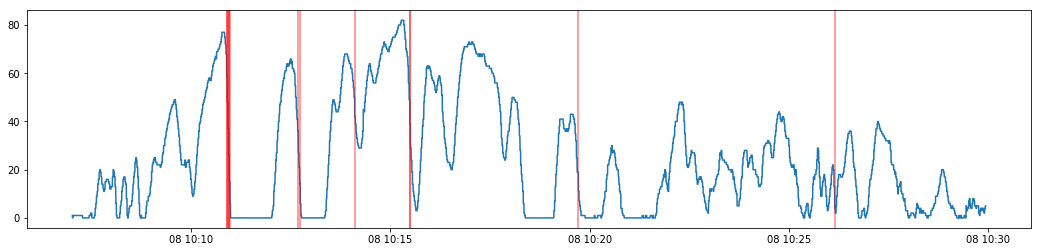

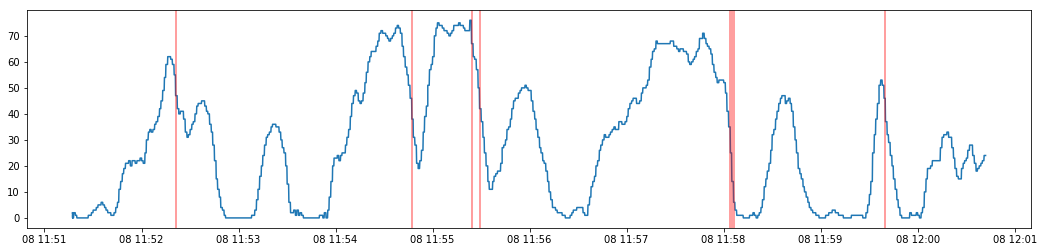

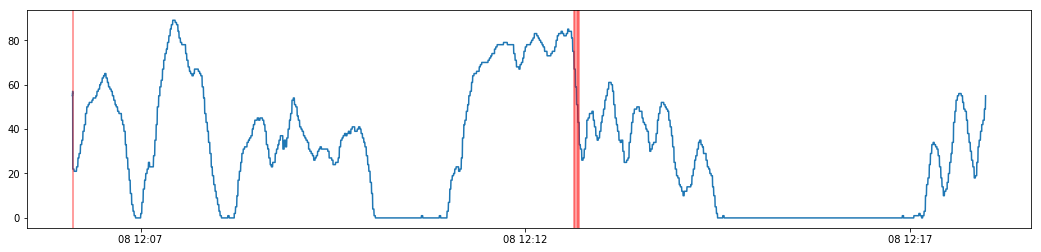

In [809]:
# standard drive speed drops

for sheet in big_df[big_df['cat_id']==0].sheet.unique():
    print(sheet)
    fig,ax = plt.subplots(figsize=(18,4))
    df = big_df[(big_df['cat_id']==0)&(big_df.sheet==sheet)]
    ax.plot(df.index, df['Speed'])

    #for stop in hard_stop_list[:115]:
    for stop in df['Speed'].diff().iteritems():
        if stop[1]<hard_Stop_threshold:
            ax.axvline(x=stop[0], color='r',alpha=0.5)


In [386]:
big_df[big_df['cat_id']==5].sheet.unique()

array(['Emergency_stop', 'Hard_Stop'], dtype=object)

### Peak utils and plots

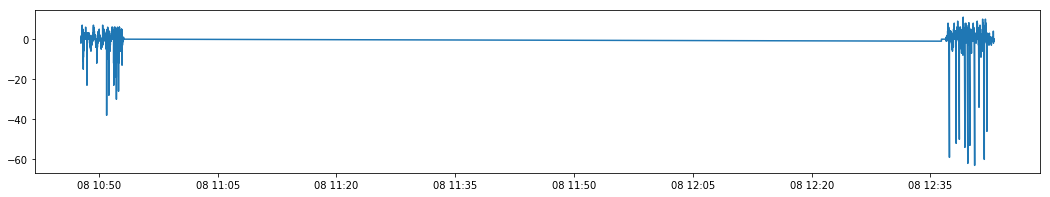

In [877]:

fig,ax = plt.subplots(figsize=(18,3))
ax.plot(big_df[big_df['cat_id']==5].index, big_df[big_df['cat_id']==5]['Speed'].diff())

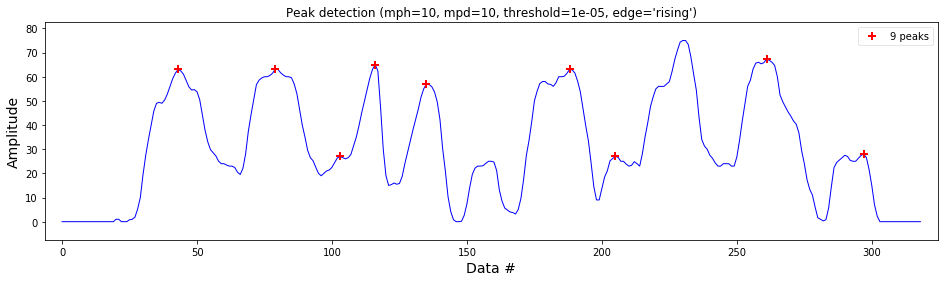

array([ 43,  79, 103, 116, 135, 188, 205, 261, 297])

In [1118]:
detect_peaks(df.groupby('time_sec')['Speed'].mean(),mph=10,mpd=10, threshold = 0.00001, show=True)

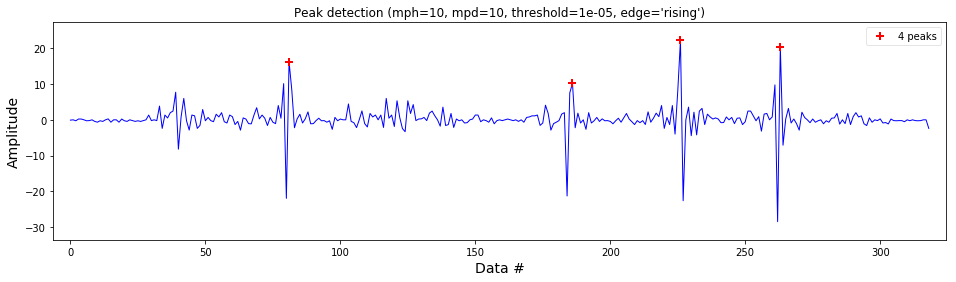

array([ 81, 186, 226, 263])

In [1119]:
detect_peaks(df.groupby('time_sec')['Vertical'].mean(),mph=10,mpd=10, threshold = 0.00001, show=True)

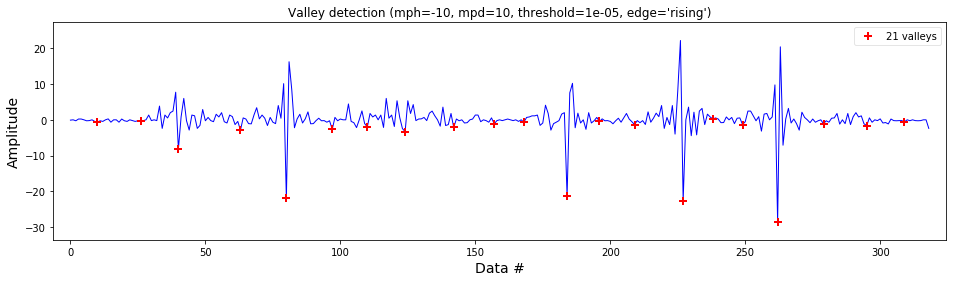

array([ 10,  26,  40,  63,  80,  97, 110, 124, 142, 157, 168, 184, 196,
       209, 227, 238, 249, 262, 279, 295, 309])

In [1140]:
detect_peaks(df.groupby('time_sec')['Vertical'].mean(),valley=True,mph=-10,mpd=10, threshold = 0.00001, show=True)

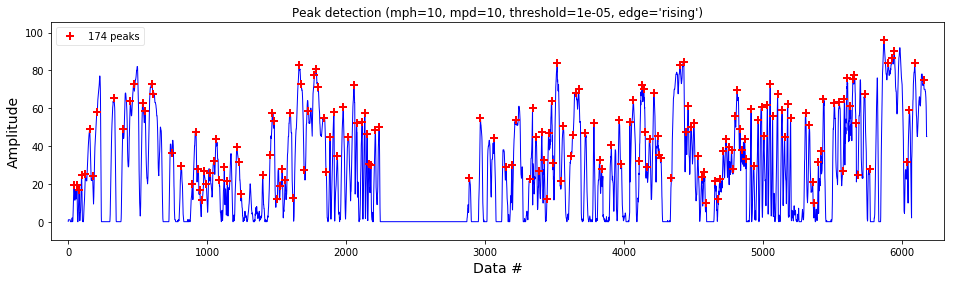

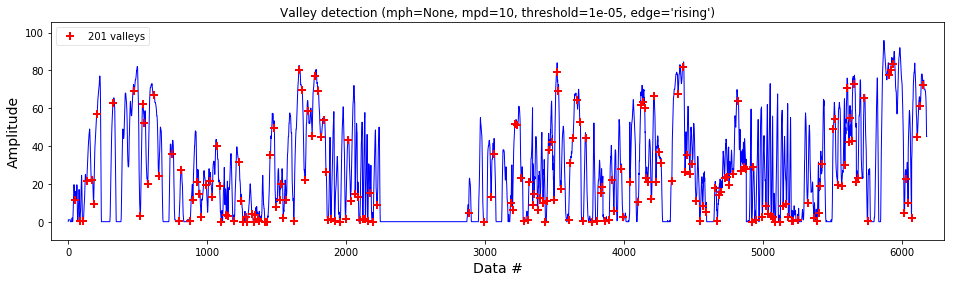

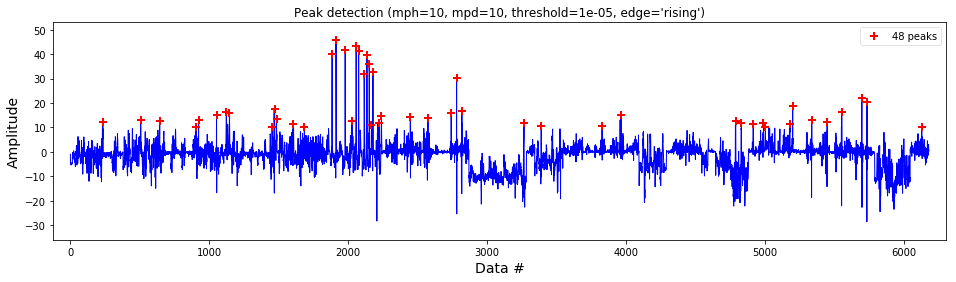

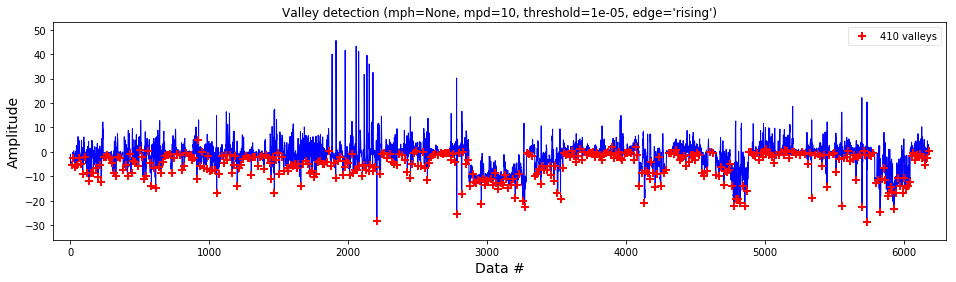

(174, 201, 48, 410)

In [1375]:
speed_peaks=detect_peaks(research_dfa.Speed,mph=10,mpd=10, threshold = 0.00001, show=True)
speed_valleys=detect_peaks(research_dfa.Speed, mpd=10,threshold = 0.00001, show=True,valley=True)

vert_peaks=detect_peaks(research_dfa.Vertical,mph=10,mpd=10, threshold = 0.00001, show=True)
vert_valleys=detect_peaks(research_dfa.Vertical, mpd=10,threshold = 0.00001, show=True,valley=True)

len(speed_peaks),len(speed_valleys),len(vert_peaks),len(vert_valleys)

In [1376]:
len(research_dfa)

6180

In [1378]:
# add peaks to dfa
peak_dict={}
for peak_type in ['speed_peaks','speed_valleys','vert_peaks','vert_valleys']:
    research_dfa[peak_type]=0
    for i,factor in enumerate([1,0.5,0.25]): # add decay
        indices = [index for index in eval(peak_type)+i if index<len(research_dfa)] #verify not too large indices
        research_dfa[peak_type].iloc[indices]=1*factor
        indices = [index for index in eval(peak_type)-i if index<len(research_dfa)]
        research_dfa[peak_type].iloc[indices]=1*factor


Emergency_stop


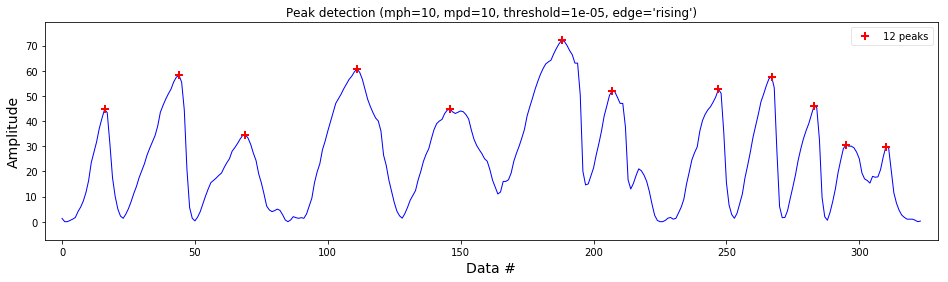

Hard_Stop


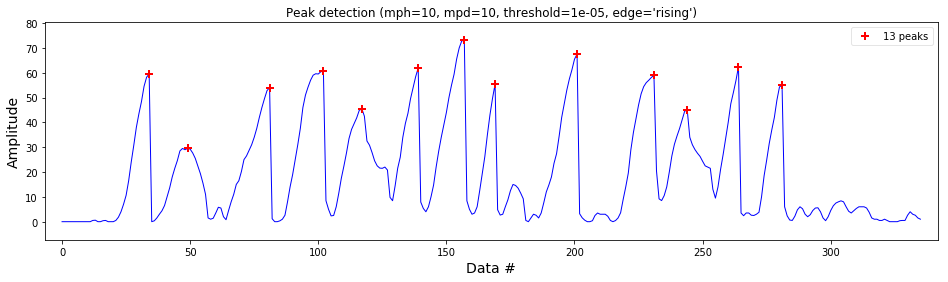

In [1107]:
# predict peaks
for sheet in big_df[big_df['cat_id']==5].sheet.unique():
    print(sheet)
    #fig,ax = plt.subplots(figsize=(18,4))
    df = big_df[(big_df['cat_id']==5)&(big_df.sheet==sheet)]
    #ax.plot(df.index, df['Speed'])
    detect_peaks(df.groupby('time_sec')['Speed'].mean(),mph=10,mpd=10, threshold = 0.00001, show=True)

## Models

### Extract features - make reserach_dfa

In [109]:
# extract features
features=['Vertical','Radial','Forward','Speed']
research_dfa = big_df.groupby('time_sec')[features].mean()\
    .join(big_df.groupby('time_sec')[features].std(), rsuffix='_std')\
    .join(big_df.groupby('time_sec')[features].max(), rsuffix='_max')\
    .join(big_df.groupby('time_sec')[features].min(), rsuffix='_min')\
   .join(big_df.groupby('time_sec')['cat_id'].max())\
    .join(big_df.groupby('time_sec')['bumper_on'].max())\
    #.join(big_df.groupby('time_sec')['hard_stop_on'].max())
    
research_dfa = research_dfa.fillna(0)

In [110]:
Counter(research_dfa.cat_id)#,sum(research_dfa.bumper_on),#sum(research_dfa.hard_stop_on)

Counter({1: 305,
         6: 5051,
         0: 1715,
         4: 2250,
         2: 1329,
         5: 627,
         3: 343,
         40: 171,
         -1: 79})

In [111]:

def get_pred_features(shift=False,moved=False,peaks=False,std=False,vert=False):

    base_feautres=['Vertical','Radial','Forward','Speed']
    func =['_max','_min','_std','']
    #for func in ['max','min','std','']:
    features=[feat+func for feat,func in itertools.product(base_feautres,func)]
    if vert:
         features=[feat+func for feat,func in itertools.product(base_feautres,func) if 'Vert' in feat]
    if std:
        features=[feat+func for feat,func in itertools.product(base_feautres,func) if 'std' in func]

    if moved:
        features+=[feat+'_moved' for feat in features if not 'shifted' in feat]
    if shift:
        
        features+=[feat+'_shifted' for feat in features if not 'moved' in feat]
    if peaks:
        features+=['speed_peaks','speed_valleys','vert_peaks','vert_valleys']

    return features

In [112]:
pred_features=get_pred_features(shift=True, moved=True)

In [113]:
# shift 
research_dfa=research_dfa.join(research_dfa.shift(-1),rsuffix='_shifted').join(research_dfa.shift(1),rsuffix='_moved')
research_dfa = research_dfa.fillna(0)


#### research dfb

In [23]:
research_dfb = research_dfa[research_dfa.cat_id.isin([0,2,3])]

In [24]:
std_features = ['Vertical_car','Radial_var','Forward_var']

In [25]:
Counter(research_dfb.cat_id)#

Counter({0: 1715, 2: 1381, 3: 343})

In [18]:
# optional: make shift
# research_dfas=research_dfa.shift().join(research_dfa,lsuffix='l')#.dropna()

### compare models for basic prediction (3 classes)

In [26]:
trn,test = train_test_split(research_dfa[research_dfa.cat_id.isin([0,2,3])],random_state=1)
len(trn), len(test)

(2579, 860)

In [27]:
Counter(research_dfb.cat_id)

Counter({0: 1715, 2: 1381, 3: 343})

In [29]:
research_dfb=research_dfb.sample(frac=1)

In [2]:
from sklearn.ensemble import RandomForestClassifier

In [1]:
# model selection
# second level models
# 91.2, but the model is too big :((

# multi layer perceptron - neural network
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
estimators=5

mlp = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(15, 10), random_state=1)
lr = LogisticRegression()
svc = svm.SVC(decision_function_shape='ovo')
# tree based models
et = ExtraTreesClassifier(n_estimators=estimators, random_state=0)
base_estimator = DecisionTreeClassifier(max_depth=4, random_state=0)
ada = AdaBoostClassifier(n_estimators=estimators,random_state=0)
rf = RandomForestClassifier(n_estimators=estimators,max_depth=10, oob_score=True, random_state=1)

models = [rf,ada,et]
model_names = ['random forest', 'ada', 'extra tree']

print('feature count', len(pred_features))
print('estimator count',estimators)
kf = KFold(n_splits=9)

for i, model in enumerate(models):
    results=[]
    for samples_train, samples_test in kf.split(research_dfb.sample(frac=1)):
        # SVM is much slower
        X_train,X_valid, y_train,y_valid = research_dfb[pred_features].iloc[samples_train],\
        research_dfb[pred_features].iloc[samples_test]\
        ,research_dfb.cat_id[samples_train],research_dfb.cat_id[samples_test]
        model.fit(X_train,y_train)
        results.append(model.score(X_valid,y_valid))
    print(model_names[i],round(np.mean(results),3),round(np.std(results),3))
    try:
        port_model(model,'test.cpp')
    except:
        print('error')

NameError: name 'LogisticRegression' is not defined

In [31]:
port_model(et,'temp.cpp')
statinfo = os.stat('temp.cpp')
statinfo.st_size


model size in bytes is:  1793970


1793970

In [32]:
model_names[i]

'extra tree'

In [33]:
model = RandomForestClassifier(n_estimators=20, oob_score=True, random_state=1,class_weight)
port_model(model,'random_forset')

SyntaxError: positional argument follows keyword argument (<ipython-input-33-8d48211707c0>, line 1)

In [34]:
# grid search for random forest
# 50 yields best value for money

models=[]
for est,depth in itertools.product([5,10,20,50,100,200],[2,5,7,10,15]):
    model = RandomForestClassifier(n_estimators=est,max_depth=depth, oob_score=False, random_state=1,\
                                  )
    results=[]
    models.append(model)
    for samples_train, samples_test in kf.split(research_dfb):
        # SVM is much slower
        X_train,X_valid, y_train,y_valid = research_dfb[pred_features].iloc[samples_train],\
        research_dfb[pred_features].iloc[samples_test]\
        ,research_dfb.cat_id[samples_train],research_dfb.cat_id[samples_test]
        model.fit(X_train,y_train)
        results.append(model.score(X_valid,y_valid))
    print(est, depth,round(np.mean(results),3),round(np.std(results),3))
    port_model(model,'temp.cpp')
    statinfo = os.stat('temp.cpp')
    print(statinfo.st_size)


5 2 0.722 0.034
model size in bytes is:  5147
5147
5 5 0.821 0.026
model size in bytes is:  33034
33034
5 7 0.852 0.018
model size in bytes is:  102827
102827
5 10 0.86 0.02
model size in bytes is:  288004
288004
5 15 0.865 0.019
model size in bytes is:  496586
496586
10 2 0.735 0.032
model size in bytes is:  9631
9631
10 5 0.832 0.018
model size in bytes is:  66569
66569
10 7 0.858 0.017
model size in bytes is:  206395
206395
10 10 0.867 0.018
model size in bytes is:  553643
553643
10 15 0.879 0.019
model size in bytes is:  969269
969269
20 2 0.738 0.03
model size in bytes is:  18657
18657
20 5 0.838 0.015
model size in bytes is:  132355
132355
20 7 0.865 0.016
model size in bytes is:  410891
410891
20 10 0.876 0.017
model size in bytes is:  1113050
1113050
20 15 0.889 0.013
model size in bytes is:  1956116
1956116
50 2 0.758 0.034
model size in bytes is:  45754
45754
50 5 0.833 0.015
model size in bytes is:  328975
328975
50 7 0.866 0.013
model size in bytes is:  994081
994081
50 10 

In [44]:
research_dfb.sample(10)

,Vertical,Radial,Forward,Speed,Vertical_std,Radial_std,Forward_std,Speed_std,Vertical_max,Radial_max,...,Speed_std_moved,Vertical_max_moved,Radial_max_moved,Forward_max_moved,Speed_max_moved,Vertical_min_moved,Radial_min_moved,Forward_min_moved,Speed_min_moved,cat_id_moved
time_sec,,,,,,,,,,,,,,,,,,,,,
2018-06-07 12:10:40,-0.266667,-1.333333,1.333333,0.600000,3.121771,3.813850,3.813850,0.495434,12.0,0.0,...,0.504695,12.0,12.0,12.0,1.0,0.0,-12.0,-12.0,0.0,0.0
2018-06-07 12:10:44,-0.222222,-0.444444,1.333333,0.000000,1.632993,2.287511,4.463690,0.000000,0.0,0.0,...,0.000000,12.0,0.0,12.0,0.0,0.0,-12.0,-12.0,0.0,0.0
2018-06-07 12:52:22,2.888889,-12.444444,-45.111111,16.500000,37.510586,18.788462,17.895574,1.514085,72.0,24.0,...,0.475831,48.0,84.0,0.0,15.0,-48.0,-36.0,-72.0,14.0,3.0
2018-06-07 12:52:25,14.000000,-21.111111,-15.555556,35.500000,32.530972,21.100538,24.739142,1.514085,84.0,24.0,...,5.234140,156.0,36.0,36.0,34.0,-180.0,-96.0,-36.0,23.0,3.0
2018-06-07 16:09:20,5.111111,15.555556,-5.777778,56.000000,23.954884,13.518215,12.497044,0.000000,48.0,36.0,...,0.809040,36.0,48.0,24.0,58.0,-24.0,0.0,-36.0,56.0,2.0
2018-06-07 10:22:05,10.222222,-11.555556,56.666667,29.500000,10.530578,9.600839,11.036817,1.514085,36.0,12.0,...,0.475831,48.0,24.0,84.0,28.0,-24.0,-24.0,24.0,27.0,0.0
2018-06-07 10:21:55,-1.276596,-47.744681,31.659574,17.297872,8.751899,3.947856,7.262999,1.999075,24.0,-36.0,...,0.475831,12.0,-24.0,36.0,20.0,-12.0,-72.0,12.0,19.0,0.0
2018-06-07 12:11:01,-0.266667,3.200000,-19.200000,9.400000,5.993936,6.472319,11.268621,2.972602,12.0,24.0,...,2.018780,24.0,24.0,-24.0,7.0,-12.0,-12.0,-48.0,3.0,0.0
2018-06-07 16:00:00,0.266667,-6.666667,14.400000,32.000000,11.000826,9.760775,11.033832,0.000000,24.0,12.0,...,1.504710,36.0,24.0,24.0,28.0,-24.0,-24.0,-36.0,24.0,2.0


In [572]:
# grid search for random forest
# 50 yields best value for money

models=[]
for est,depth in itertools.product([5,10,20,50,100,200],[2,5,7,10,15]):
    model = RandomForestClassifier(n_estimators=est,max_depth=depth, oob_score=False, random_state=1,\
                                  )
    results=[]
    models.append(model)
    for samples_train, samples_test in kf.split(research_dfb):
        # SVM is much slower
        X_train,X_valid, y_train,y_valid = research_dfb[pred_features].iloc[samples_train],\
        research_dfb[pred_features].iloc[samples_test]\
        ,research_dfb.cat_id[samples_train],research_dfb.cat_id[samples_test]
        model.fit(X_train,y_train)
        results.append(model.score(X_valid,y_valid))
    print(est, depth,round(np.mean(results),3),round(np.std(results),3))

5 2 0.827 0.013
5 5 0.873 0.007
5 7 0.871 0.01
5 10 0.876 0.006
5 15 0.876 0.006
10 2 0.829 0.013
10 5 0.872 0.009
10 7 0.875 0.006
10 10 0.878 0.008
10 15 0.886 0.013
20 2 0.822 0.007
20 5 0.873 0.009
20 7 0.878 0.01
20 10 0.883 0.008
20 15 0.885 0.01
50 2 0.825 0.01
50 5 0.874 0.009
50 7 0.877 0.011
50 10 0.88 0.01
50 15 0.893 0.011
100 2 0.823 0.008
100 5 0.873 0.009
100 7 0.877 0.01
100 10 0.88 0.008
100 15 0.89 0.01
200 2 0.823 0.008
200 5 0.874 0.009
200 7 0.877 0.01
200 10 0.878 0.01
200 15 0.89 0.01


In [573]:
port_model(models[13],'rf_20_10.cpp')

In [40]:
kf = KFold(n_splits=10)

In [42]:
len(pred_features)

32

In [41]:
models=[]
for i in [5,10,15,50]:
    model =  ExtraTreesClassifier(n_estimators=i, random_state=0)
    results=[]
    models.append(model)
    for samples_train, samples_test in kf.split(research_dfb):
        # SVM is much slower
        X_train,X_valid, y_train,y_valid = research_dfb[pred_features].iloc[samples_train],\
        research_dfb[pred_features].iloc[samples_test]\
        ,research_dfb.cat_id[samples_train],research_dfb.cat_id[samples_test]
        model.fit(X_train,y_train)
        results.append(model.score(X_valid,y_valid))
    print(i,round(np.mean(results),3),round(np.std(results),3))
    port_model(model,'temp.cpp')

5 0.865 0.011
model size in bytes is:  1860013
10 0.878 0.012
model size in bytes is:  3682469
15 0.885 0.012
model size in bytes is:  5452031
50 0.896 0.017
model size in bytes is:  18069910


In [47]:
kf = KFold(n_splits=5)
models=[]
for i in [0.5,0.7,1]:
    data = research_dfb.sample(frac=i)
    model =  ExtraTreesClassifier(n_estimators=10, random_state=0)
    results=[]
    models.append(model)
    for samples_train, samples_test in kf.split(data):
        # SVM is much slower
        X_train,X_valid, y_train,y_valid = data[pred_features].iloc[samples_train],\
        data[pred_features].iloc[samples_test]\
        ,data.cat_id[samples_train],data.cat_id[samples_test]
        model.fit(X_train,y_train)
        results.append(model.score(X_valid,y_valid))
    print(i,round(np.mean(results),3),round(np.std(results),3))
    port_model(model,'temp.cpp')

0.5 0.861 0.011
model size in bytes is:  1725815
0.7 0.865 0.006
model size in bytes is:  2254278
1 0.876 0.01
model size in bytes is:  3250784


In [51]:
X_train.iloc[0]

Vertical_max            36.000000
Vertical_min           -24.000000
Vertical_std            16.176697
Vertical                 4.222222
Radial_max              36.000000
Radial_min              12.000000
Radial_std               8.392869
Radial                  24.444444
Forward_max             36.000000
Forward_min            -24.000000
Forward_std             18.447955
Forward                  3.555556
Speed_max               63.000000
Speed_min               61.000000
Speed_std                0.752355
Speed                   61.333333
Vertical_max_shifted    48.000000
Vertical_min_shifted   -24.000000
Vertical_std_shifted    15.435496
Vertical_shifted         8.800000
Radial_max_shifted      36.000000
Radial_min_shifted       0.000000
Radial_std_shifted       8.968632
Radial_shifted          16.533333
Forward_max_shifted     24.000000
Forward_min_shifted    -36.000000
Forward_std_shifted     11.485960
Forward_shifted         -2.933333
Speed_max_shifted       61.000000
Speed_min_shif

In [54]:
model.predict_proba([X_train.iloc[0]])

array([[0., 1., 0.]])

In [1712]:
# feature importence
pd.DataFrame([(i,j) for (i,j) in zip(model.feature_importances_,pred_features+shifted_features)],columns=['importence','feature'])\
    .sort_values(by='importence',ascending=False)

,importence,feature
25,0.082483,Vertical_min_shifted
34,0.069430,Forward_std_shifted
22,0.054781,Forward_std_moved
10,0.043958,Forward_std
26,0.035841,Vertical_std_shifted
24,0.035709,Vertical_max_shifted
14,0.035596,Vertical_std_moved
2,0.031360,Vertical_std
35,0.030582,Forward_shifted
13,0.030525,Vertical_min_moved


In [55]:
pred_features

['Vertical_max',
 'Vertical_min',
 'Vertical_std',
 'Vertical',
 'Radial_max',
 'Radial_min',
 'Radial_std',
 'Radial',
 'Forward_max',
 'Forward_min',
 'Forward_std',
 'Forward',
 'Speed_max',
 'Speed_min',
 'Speed_std',
 'Speed',
 'Vertical_max_shifted',
 'Vertical_min_shifted',
 'Vertical_std_shifted',
 'Vertical_shifted',
 'Radial_max_shifted',
 'Radial_min_shifted',
 'Radial_std_shifted',
 'Radial_shifted',
 'Forward_max_shifted',
 'Forward_min_shifted',
 'Forward_std_shifted',
 'Forward_shifted',
 'Speed_max_shifted',
 'Speed_min_shifted',
 'Speed_std_shifted',
 'Speed_shifted']

In [ ]:
Current(MAX,MIN,STD,AVG): Vertical(  0.00,-12.00,  4.32, -1.92) Radial(  0.00,-48.00,  4.27,-34.80) Forward( 24.00, 12.00,  5.42, 15.60) Speed(  0.00,  0.00,  0.00,  0.00)
Moved(MAX,MIN,STD,AVG): Vertical(  0.00,-12.00,  4.32, -1.92) Radial(  0.00,-36.00,  4.32,-34.08) Forward( 24.00, 12.00,  5.89, 17.04) Speed(  0.00,  0.00,  0.00,  0.00)
Shifted(MAX,MIN,STD,AVG): Vertical(  0.00,-12.00,  4.53, -2.16) Radial(  0.00,-36.00,  4.07,-34.32) Forward( 24.00, 12.00,  5.10, 14.88) Speed(  0.00,  0.00,  0.00,  0.00)

### Sanity test

In [83]:
pred_features

['Vertical_max',
 'Vertical_min',
 'Vertical_std',
 'Vertical',
 'Radial_max',
 'Radial_min',
 'Radial_std',
 'Radial',
 'Forward_max',
 'Forward_min',
 'Forward_std',
 'Forward',
 'Speed_max',
 'Speed_min',
 'Speed_std',
 'Speed',
 'Vertical_max_moved',
 'Vertical_min_moved',
 'Vertical_std_moved',
 'Vertical_moved',
 'Radial_max_moved',
 'Radial_min_moved',
 'Radial_std_moved',
 'Radial_moved',
 'Forward_max_moved',
 'Forward_min_moved',
 'Forward_std_moved',
 'Forward_moved',
 'Speed_max_moved',
 'Speed_min_moved',
 'Speed_std_moved',
 'Speed_moved',
 'Vertical_max_shifted',
 'Vertical_min_shifted',
 'Vertical_std_shifted',
 'Vertical_shifted',
 'Radial_max_shifted',
 'Radial_min_shifted',
 'Radial_std_shifted',
 'Radial_shifted',
 'Forward_max_shifted',
 'Forward_min_shifted',
 'Forward_std_shifted',
 'Forward_shifted',
 'Speed_max_shifted',
 'Speed_min_shifted',
 'Speed_std_shifted',
 'Speed_shifted']

In [91]:
input_0 =[0.00, -12.00,  4.32, -1.92, 0.00, -48.00,  4.27,-34.80,4.00, 12.00,  5.42, 15.60,  0.00,  0.00,  0.00,  0.00
       ,  0.00, -12.00,  4.32, -1.92, 0.00, -36.00,  4.32, -34.08, 24.00, 12.00,  5.89, 17.04, 0.00,  0.00,  0.00,  0.00
                , 0.00,-12.00,  4.53, -2.16, 0.00,-36.00,  4.07,-34.32, 24.00, 12.00,  5.10, 14.88,  0.00,  0.00,  0.00,  0.00]

In [99]:
input_1=[  0.00,-12.00,  4.32, -1.92, 0.00,-36.00,  4.32,-34.08, 24.00, 12.00,  5.89, 17.04, 0.00,  0.00,  0.00,  0.00,
 0.00,-12.00,  5.35, -3.36, 0.00,-48.00,  3.66,-35.28, 24.00, 12.00,  5.35, 15.36,  0.00,  0.00,  0.00,  0.00,
0.00,-12.00,  4.32, -1.92, 0.00,-48.00,  4.27,-34.80, 24.00, 12.00,  5.42, 15.60,  0.00,  0.00,  0.00,  0.00]

In [100]:
len(input_1)

48

In [114]:
data = X_train.sample(frac=1)

In [98]:
X_train

NameError: name 'X_train' is not defined

In [129]:
colors=['r', 'b']

In [147]:
np.round_(data.iloc[2].values)

array([  36.,  -84.,   27.,   -4.,  132.,    0.,   40.,   64.,   24.,
        -24.,   12.,    0.,   35.,   25.,    4.,   27.,   36.,  -60.,
         22.,    6.,  204.,   36.,   27.,   94.,   36.,  -36.,   18.,
         -1.,   42.,   35.,    3.,   36.,  156., -156.,   83.,   19.,
         72.,  -36.,   27.,   15.,   24.,  -36.,   14.,   -1.,   25.,
         13.,    5.,   15.])

In [ ]:
36.,  -84.,   27.,   -4.,  132.,    0.,   40.,   64.,   24.,  -24.,   12.,    0.,   35.,   25.,    4.,   27.,   36.,  -60.,
 22.,    6.,  204.,   36.,   27.,   94.,   36.,  -36.,   18., -1.,   42.,   35.,    3.,   36.,  156., -156.,   83.,   19.,
72.,  -36.,   27.,   15.,   24.,  -36.,   14.,   -1.,   25.,  13.,    5.,   15.

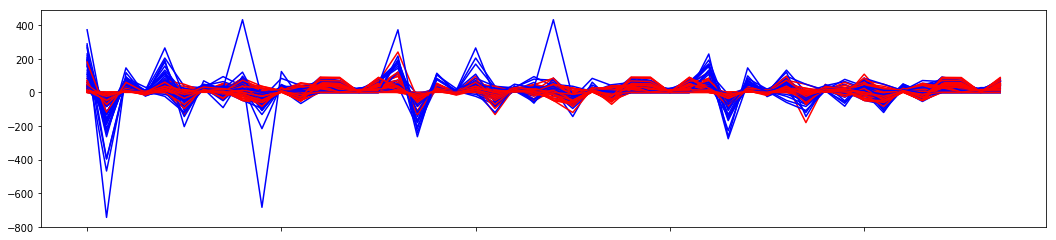

In [132]:
i=100
data.iloc[:i].T.plot(legend=False,figsize=(18,4),color=[colors[i] for i in preds[:i]])

In [125]:
preds=model.predict(data)

In [ ]:
Current(MAX,MIN,STD,AVG): Vertical(  0.00,-12.00,  4.32, -1.92) Radial(  0.00,-48.00,  4.27,-34.80) Forward( 24.00, 12.00,  5.42, 15.60) Speed(  0.00,  0.00,  0.00,  0.00)
Moved(MAX,MIN,STD,AVG): Vertical(  0.00,-12.00,  4.32, -1.92) Radial(  0.00,-36.00,  4.32,-34.08) Forward( 24.00, 12.00,  5.89, 17.04) Speed(  0.00,  0.00,  0.00,  0.00)
Shifted(MAX,MIN,STD,AVG): Vertical(  0.00,-12.00,  4.53, -2.16) Radial(  0.00,-36.00,  4.07,-34.32) Forward( 24.00, 12.00,  5.10, 14.88) Speed(  0.00,  0.00,  0.00,  0.00)

### Predict Bumper

In [ ]:
# build data set out of bumper-datapoints and standard drive data pointץ
# its a bit degenerated, but this is Phase 1
# phase 2 will be with differnt data...

In [114]:
sum(research_dfa.cat_id==40),sum(research_dfa.cat_id==50)

(171, 0)

In [115]:
len(research_dfa)

11870

#### Under Samling

In [118]:
# 1. equal data sets
    #  problem: good recall, but low percision on full data set
bumpers_df=research_dfa[research_dfa.cat_id.isin([0,1,2,3])].sample(int(sum(research_dfa.cat_id==40)*1.2))\
    .append(research_dfa[research_dfa.bumper_on==1])



In [119]:
len(bumpers_df)

376

In [120]:
### Models

# multi layer perceptron - neural network
mlp = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(15, 10), random_state=1)
lr = LogisticRegression()
svc = svm.SVC(decision_function_shape='ovo')
# tree based models
et = ExtraTreesClassifier(n_estimators=15, random_state=0)
base_estimator = DecisionTreeClassifier(max_depth=4, random_state=0)
ada = AdaBoostClassifier(n_estimators=10,random_state=0)
rf = RandomForestClassifier(n_estimators=50,max_depth=10, oob_score=True, random_state=1)

In [121]:
pred_features=get_pred_features(shift=True,moved=True)

In [122]:
pred_features+=['cat_id']

In [123]:
bumpers_df.loc[bumpers_df.cat_id.isin([40]),'cat_id']=0

In [124]:
bumpers_df.columns

Index(['Vertical', 'Radial', 'Forward', 'Speed', 'Vertical_std', 'Radial_std',
       'Forward_std', 'Speed_std', 'Vertical_max', 'Radial_max', 'Forward_max',
       'Speed_max', 'Vertical_min', 'Radial_min', 'Forward_min', 'Speed_min',
       'cat_id', 'bumper_on', 'Vertical_shifted', 'Radial_shifted',
       'Forward_shifted', 'Speed_shifted', 'Vertical_std_shifted',
       'Radial_std_shifted', 'Forward_std_shifted', 'Speed_std_shifted',
       'Vertical_max_shifted', 'Radial_max_shifted', 'Forward_max_shifted',
       'Speed_max_shifted', 'Vertical_min_shifted', 'Radial_min_shifted',
       'Forward_min_shifted', 'Speed_min_shifted', 'cat_id_shifted',
       'bumper_on_shifted', 'Vertical_moved', 'Radial_moved', 'Forward_moved',
       'Speed_moved', 'Vertical_std_moved', 'Radial_std_moved',
       'Forward_std_moved', 'Speed_std_moved', 'Vertical_max_moved',
       'Radial_max_moved', 'Forward_max_moved', 'Speed_max_moved',
       'Vertical_min_moved', 'Radial_min_moved', 'Forward

In [125]:
pred_features=get_pred_features(shift=True,moved=True)

In [128]:
# model selection for bumpers
# .799 for bumpers .86 with peaks
#  more data (8.5) improves extra trees to 0/.9
models = [lr,svc, mlp,rf,ada,et]
model_names = ['lr','svc', 'mlp', 'random forest', 'ada', 'extra tree']

kf = KFold(n_splits=5, shuffle=True)

for i, model in enumerate(models):
    results=[]
    for samples_train, samples_test in kf.split(bumpers_df):
        # SVM is bit slower
        X_train,X_valid, y_train,y_valid = bumpers_df[pred_features].iloc[samples_train],\
            bumpers_df[pred_features].iloc[samples_test]\
            ,bumpers_df.bumper_on[samples_train],bumpers_df.bumper_on[samples_test]
        model.fit(X_train,y_train)
        results.append(model.score(X_valid,y_valid))
        #print(cm(bumpers_df.bumper_on[samples_test],et.predict( bumpers_df[pred_features].iloc[samples_test])))
    print(model_names[i],round(np.mean(results),3),round(np.std(results),3))

AttributeError: module 'numpy.random' has no attribute 'mtrand'

In [1749]:
#port_model(et,'bumpers_et_0.93_36.cpp')

In [82]:
cm(bumpers_df.bumper_on[samples_test],model.predict( bumpers_df[pred_features].iloc[samples_test]))

array([[34,  1],
       [ 6, 34]])

#### Over sampling - hacking

In [103]:
means=research_dfa.mean()
stds=research_dfa.std()

In [104]:
noise={}
for col,mean,std in zip(research_dfa.columns,means,stds):
    noise_unit = np.random.normal(mean,std,800)
    noise[col]=noise_unit

In [105]:
noise_df=pd.DataFrame(noise)
noise_df['bumper_on']=1

In [106]:
# 1. equal data sets
bumpers_df=research_dfa[research_dfa.cat_id.isin([0,1,2,3])].sample(1400)\
    .append(research_dfa[research_dfa.bumper_on==1]).append(noise_df)

In [107]:
len(bumpers_df)

2333

In [108]:
pred_features = [feat for feat in pred_features if 'speed' not in feat.lower()]

In [109]:
# multi layer perceptron - neural network
# mlp = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(15, 10), random_state=1)
# lr = LogisticRegression()
# svc = svm.SVC(decision_function_shape='ovo')
# # tree based models
et = ExtraTreesClassifier(n_estimators=5, random_state=0)
base_estimator = DecisionTreeClassifier(max_depth=4, random_state=0)
ada = AdaBoostClassifier(n_estimators=10,random_state=0)
rf = RandomForestClassifier(n_estimators=50,max_depth=10, oob_score=True, random_state=1)

In [110]:
# model selection for bumpers
# .799 for bumpers .86 with peaks
#  more data (8.5) improves extra trees to 0/.9
models = [rf,ada,et]
model_names = ['random forest', 'ada', 'extra tree']

for i, model in enumerate(models):
    results=[]
    for samples_train, samples_test in kf.split(bumpers_df.sample(frac=1)):
        # SVM is bit slower
        X_train,X_valid, y_train,y_valid = bumpers_df[pred_features].iloc[samples_train],\
            bumpers_df[pred_features].iloc[samples_test]\
            ,bumpers_df.bumper_on[samples_train],bumpers_df.bumper_on[samples_test]
        model.fit(X_train,y_train)
        results.append(model.score(X_valid,y_valid))
    print(model_names[i],round(np.mean(results),3),round(np.std(results),3))

random forest 0.878 0.015
ada 0.827 0.048
extra tree 0.883 0.032


In [1730]:
len(pred_features)

36

In [1738]:
# port_model(et,'bumpers_et_0.976_36f.cpp')

In [113]:
et.predict( bumpers_df[pred_features])

array([0, 0, 0, ..., 1, 1, 1])

In [116]:
Counter(bumpers_df.bumper_on)

Counter({0: 1400, 1: 933})

In [117]:
cm(bumpers_df.bumper_on,et.predict( bumpers_df[pred_features]))

array([[1400,    0],
       [  59,  874]])

#### SMOTE

In [ ]:
from imblearn import over_sampling
sm = SMOTE(random_state=42)

In [ ]:
X_res, y_res=sm.fit_sample(research_dfa[pred_features],research_dfa['hit'])

### Predict hard stops

In [ ]:
    
hard_stops_df=research_dfa[research_dfa.cat_id==0].sample(70).append(research_dfa[research_dfa.hard_stop_on==1])


In [1628]:
# model selection - Hard stops
# .97 extra trees. ada gives 98 with peaks

models = [lr,svc, mlp,rf,ada,et]
model_names = ['lr','svc', 'mlp', 'random forest', 'ada', 'extra tree']

for i, model in enumerate(models):
    results=[]
    for samples_train, samples_test in kf.split(hard_stops_df.sample(frac=1)):
        # SVM is much slower
        X_train,X_valid, y_train,y_valid = hard_stops_df[pred_features].iloc[samples_train],\
            hard_stops_df[pred_features].iloc[samples_test]\
            ,hard_stops_df.hard_stop_on[samples_train],hard_stops_df.hard_stop_on[samples_test]
        model.fit(X_train,y_train)
        results.append(model.score(X_valid,y_valid))
    print(model_names[i],round(np.mean(results),3),round(np.std(results),3))

lr 0.817 0.043
svc 0.542 0.065
mlp 0.928 0.013
random forest 0.902 0.071
ada 0.85 0.047
extra tree 0.915 0.052


In [1415]:
# model selection - Hard stops and Bumpers

models = [lr,svc, mlp,rf,ada,et]
model_names = ['lr','svc', 'mlp', 'random forest', 'ada', 'extra tree']

for i, model in enumerate(models):
    results=[]
    for samples_train, samples_test in kf.split(momentary_df):
        # SVM is much slower
        X_train,X_valid, y_train,y_valid = momentary_df[pred_features].iloc[samples_train],\
            momentary_df[pred_features].iloc[samples_test]\
            ,momentary_df.momentary_cat[samples_train],momentary_df.momentary_cat[samples_test]
        model.fit(X_train,y_train)
        results.append(model.score(X_valid,y_valid))
    print(model_names[i],round(np.mean(results),3),round(np.std(results),3))

lr 0.784 0.013
svc 0.516 0.024
mlp 0.726 0.034
random forest 0.875 0.031
ada 0.737 0.07
extra tree 0.862 0.015


### All classes model

In [ ]:
momentary_df = bumpers_df.append(hard_stops_df)
momentary_df['momentary_cat'] =research_dfa.bumper_on+research_dfa.hard_stop_on*2

In [941]:
pred_features+=['peak']

In [946]:
pred_features=pred_features[:-1]

In [1481]:
# 0.778 with peaks, .78 w/o peaks :)
# .83 with shift and move
# remove hard stop
models = [lr,svc, mlp,rf,ada,et]
model_names = ['lr','svc', 'mlp', 'random forest', 'ada', 'extra tree']

for i, model in enumerate(models):
    results=[]
    for sm_trn, sm_test in kf.split(research_dfa[research_dfa.cat_id.isin([0,1,2,3,40])]):
        # SVM is much slower
        X_trn,X_val, y_trn,y_val = research_dfa[pred_features].iloc[sm_trn],research_dfa[pred_features].iloc[sm_test]\
            ,research_dfa.cat_id[sm_trn],research_dfa.cat_id[sm_test]
        model.fit(X_trn,y_trn)
        results.append(model.score(X_val,y_val))
    print(model_names[i],round(np.mean(results),3),round(np.std(results),3))

lr 0.707 0.014
svc 0.533 0.026
mlp 0.76 0.011
random forest 0.796 0.013
ada 0.612 0.008
extra tree 0.829 0.008


In [876]:
# toy problem

models = [lr,svc, mlp,rf,ada,et]
model_names = ['lr','svc', 'mlp', 'random forest', 'ada', 'extra tree']

for i, model in enumerate(models):
    results=[]
    for sm_trn, sm_test in kf.split(research_dfa):
        # SVM is much slower
        X_trn,X_val, y_trn,y_val = research_dfa[pred_features].iloc[sm_trn],research_dfa[pred_features].iloc[sm_test]\
            ,research_dfa.cat_id[sm_trn],research_dfa.cat_id[sm_test]
        model.fit(X_trn,y_trn)
        results.append(model.score(X_val,y_val))
    print(model_names[i],round(np.mean(results),3),round(np.std(results),3))

lr 0.578 0.017
svc 0.503 0.014
mlp 0.628 0.013
random forest 0.697 0.021
ada 0.465 0.039
extra tree 0.707 0.016


In [1032]:
Counter(research_dfa.cat_id[sm_trn])

Counter({0: 1564, 2: 205, 3: 119, 4: 720, 5: 245, 40: 31})

## Plots

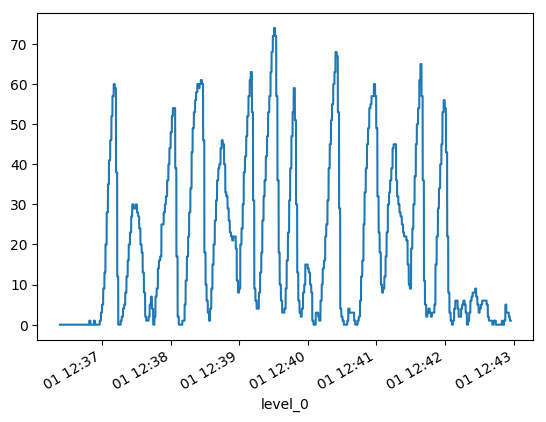

In [256]:
big_df[(big_df['file']=='Acc_Test_240418.xlsx')&(big_df.cat_id==5)]['Speed'].plot()

In [324]:
# ad ma column
big_df['speed_ma_100']\
=pd.rolling_mean(big_df[(big_df['file']=='Acc_Test_240418.xlsx')&(big_df.cat_id==5)]['Speed'],100).fillna(0)

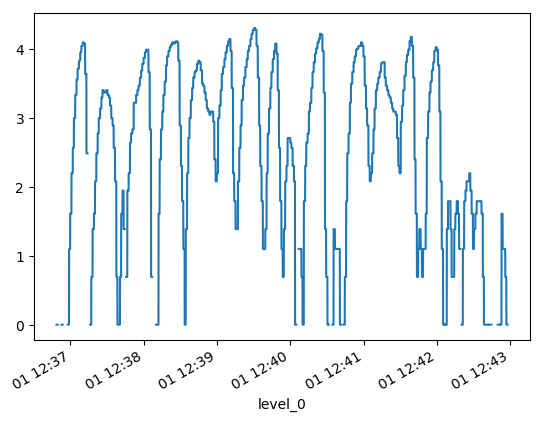

In [258]:
big_df[(big_df['file']=='Acc_Test_240418.xlsx')&(big_df.cat_id==5)]['Speed'].apply(lambda x:np.log(np.abs(x))).plot()

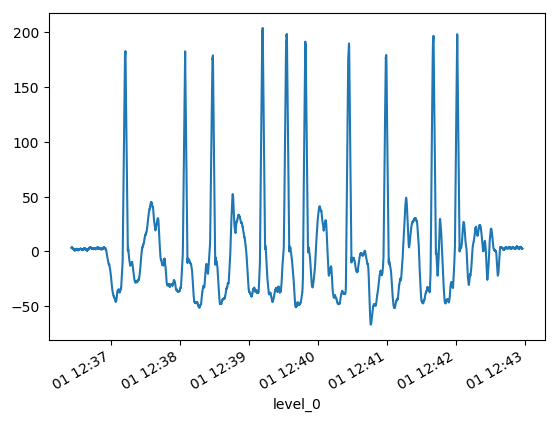

In [225]:
pd.rolling_mean(big_df[(big_df['file']=='Acc_Test_240418.xlsx')&(big_df.cat_id==5)]['Forward'],100).plot()

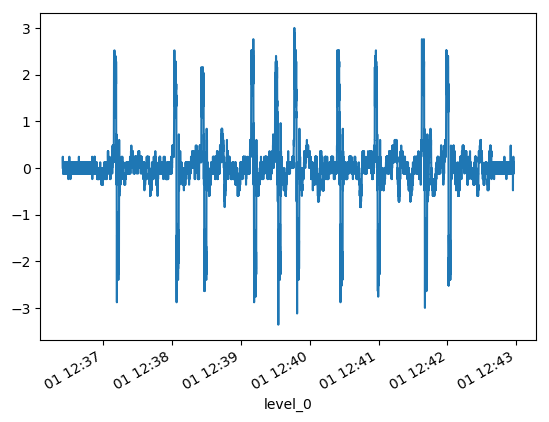

In [236]:
pd.rolling_mean(big_df[(big_df['file']=='Acc_Test_240418.xlsx')&(big_df.cat_id==5)]['Forward'],100).diff().plot()

In [241]:
sum(pd.rolling_mean(big_df[(big_df['file']=='Acc_Test_240418.xlsx')&(big_df.cat_id==5)]['Forward'],100).diff()>1)

1010

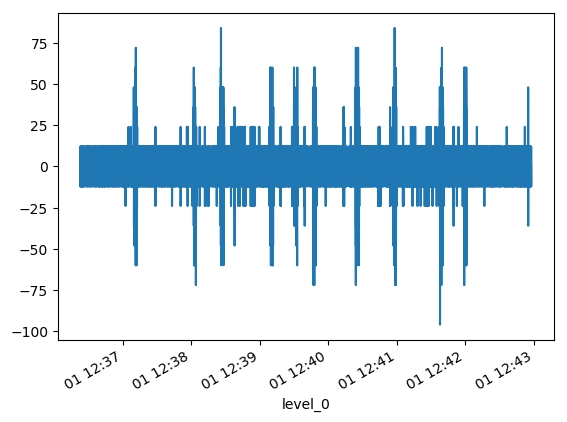

In [237]:
big_df[(big_df['file']=='Acc_Test_240418.xlsx')&(big_df.cat_id==5)]['Forward'].diff().plot()

In [239]:
sum(big_df[(big_df['file']=='Acc_Test_240418.xlsx')&(big_df.cat_id==5)]['Forward'].diff()>50)

22

### Annotate stops

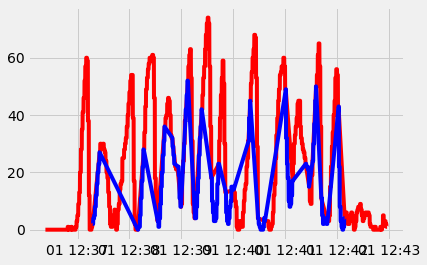

In [200]:

plt.plot(big_df[(big_df['file']=='Acc_Test_240418.xlsx')&(big_df.cat_id==5)&(big_df['hard_stop_on']==0)]['Speed'], color='r')
plt.plot(big_df[(big_df['file']=='Acc_Test_240418.xlsx')&(big_df.cat_id==5)&(big_df['hard_stop_on']==1)]['Speed'], color='b')
plt.show()

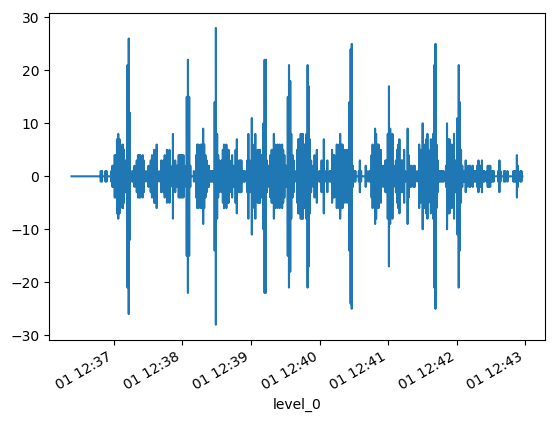

In [221]:
big_df[(big_df['file']=='Acc_Test_240418.xlsx')&(big_df.cat_id==5)].Speed.diff().diff().plot()

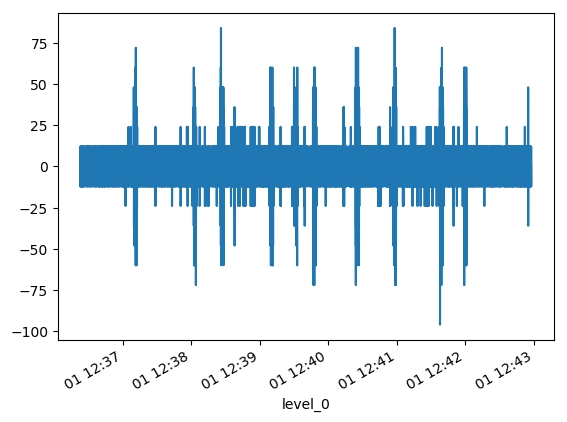

In [234]:
big_df[(big_df['file']=='Acc_Test_240418.xlsx')&(big_df.cat_id==5)].Forward.diff().plot()

In [187]:
len(big_df[(big_df['file']=='Acc_Test_240418.xlsx')&(big_df.cat_id==5)].isna())

24236

In [93]:
# move to sql to tag hardstops correctly
#or generate another table

In [130]:
import datetime
hard_stops['start time'].iloc[0]+ datetime.timedelta(0,1) 

Timestamp('2018-05-01 12:37:18')

In [215]:
np.mean(big_df[(big_df['file']=='Acc_Test_240418.xlsx')&(big_df.cat_id==5)&(big_df['hard_stop_on']==1)]['Speed'])

14.284299858557285

In [224]:
np.mean(big_df[(big_df['file']=='Acc_Test_240418.xlsx')&(big_df['hard_stop_on']==0)]['Speed'])

29.64387046907457

In [223]:
np.mean(big_df[(big_df['file']=='Acc_Test_240418.xlsx')&(big_df['hard_stop_on']==1)]['Speed'].diff())

0.0004042037186742118

In [287]:
speed=big_df[(big_df['file']=='Acc_Test_240418.xlsx')&(big_df.cat_id==5)]['Speed']

In [274]:
big_df['speed_diff'] = big_df['Speed'] - big_df['Speed'].shift()  

In [275]:
big_df['speed_diff_1']=big_df['speed_diff'] .shift(1)

## Time series statistcs

In [ ]:
# takes some time
# Examine join distribution
sb.jointplot('speed_diff_1', 'speed_diff', big_df, kind='reg', size=4)

In [278]:
# test auto correlcation
# takes some time
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
lag_correlations = acf(big_df['speed_diff'].iloc[1:])  
lag_partial_correlations = pacf(big_df['speed_diff'].iloc[1:])

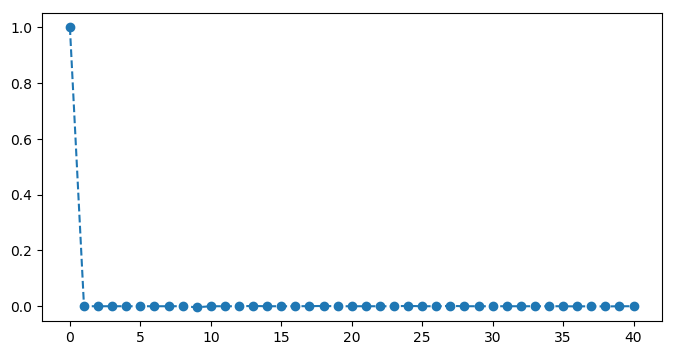

In [282]:
fig, ax = plt.subplots(figsize=(8,4))  
ax.plot(lag_correlations, marker='o', linestyle='--')

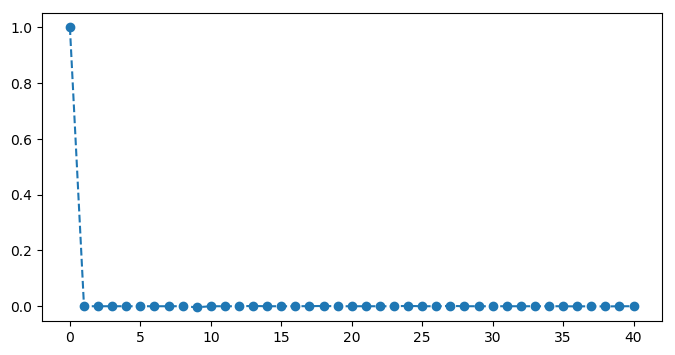

In [284]:
fig, ax = plt.subplots(figsize=(8,4))  
ax.plot(lag_partial_correlations, marker='o', linestyle='--')

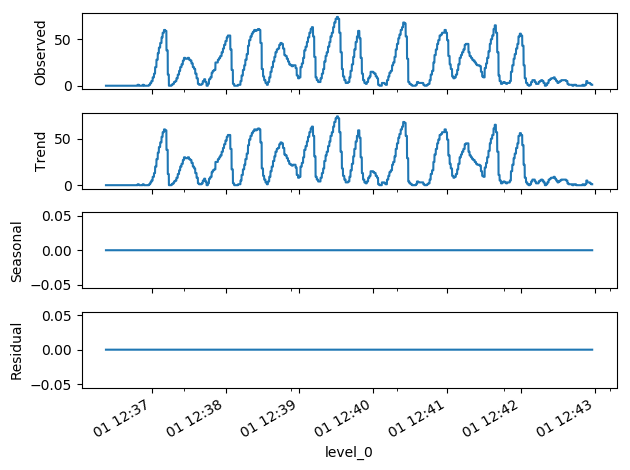

In [290]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(speed, model='additive', freq=1)  
fig = plt.figure()  
fig = decomposition.plot()

In [326]:
model

In [329]:
results.fittedvalues[300:320]

level_0
2018-05-01 12:36:28.946249216    0.000139
2018-05-01 12:36:28.966249984    0.000139
2018-05-01 12:36:28.986250752    0.000139
2018-05-01 12:36:29.006251520    0.000139
2018-05-01 12:36:29.026252288    0.000139
2018-05-01 12:36:29.046253312    0.000139
2018-05-01 12:36:29.066254080    0.000139
2018-05-01 12:36:29.086254848    0.000139
2018-05-01 12:36:29.106255616    0.000139
2018-05-01 12:36:29.126256640    0.000139
2018-05-01 12:36:29.146257408    0.000139
2018-05-01 12:36:29.166258176    0.000139
2018-05-01 12:36:29.186258944    0.000139
2018-05-01 12:36:29.206259712    0.000139
2018-05-01 12:36:29.226260736    0.000139
2018-05-01 12:36:29.246261504    0.000139
2018-05-01 12:36:29.266262272    0.000139
2018-05-01 12:36:29.286263040    0.000139
2018-05-01 12:36:29.306264064    0.000139
2018-05-01 12:36:29.326264832    0.000139
dtype: float64

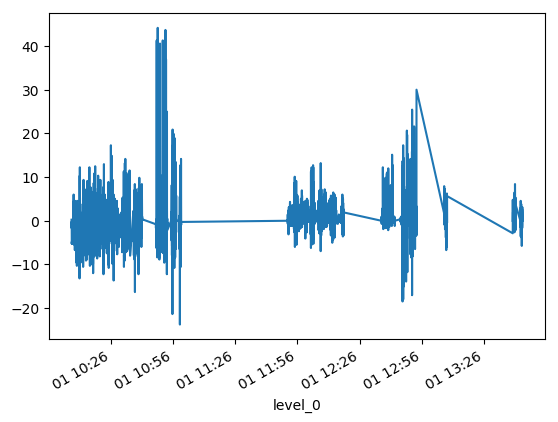

In [334]:
research_dfa.Vertical.iloc[1:].plot()

In [336]:
big_df.keys()

Index(['Vertical', 'Forward', 'Radial', 'Speed', 'Ignition', 'level_0', 'file',
       'sheet', 'cat_id', 'hard_stop_on', 'speed_diff', 'speed_diff_1',
       'speed_ma_100'],
      dtype='object')

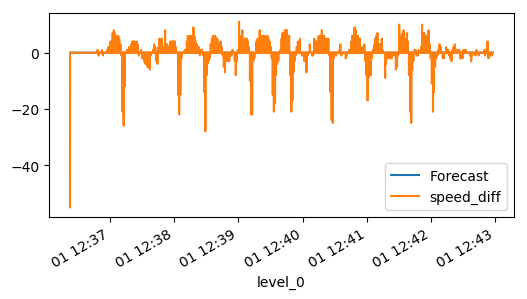

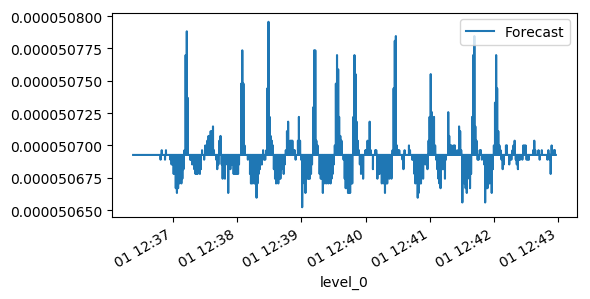

In [341]:
import statsmodels.api as sm 

data=big_df[(big_df['file']=='Acc_Test_240418.xlsx')&(big_df.cat_id==5)]
model = sm.tsa.ARIMA(data['speed_diff'].iloc[1:], order=(1, 0, 0))  
results = model.fit(disp=-1)  

data['Forecast'] = results.fittedvalues  
data[['Forecast','speed_diff']].plot(figsize=(6, 3))
data[['Forecast']].plot(figsize=(6, 3))

In [342]:
big_df.head()

,Vertical,Forward,Radial,Speed,Ignition,level_0,file,sheet,cat_id,hard_stop_on,speed_diff,speed_diff_1,speed_ma_100
level_0,,,,,,,,,,,,,
2018-05-01 10:07:00.964000000,0.0,24.0,0.0,1.0,1.0,2018-05-01 10:07:01,Acc_Data_Toyota_2604.xlsx,REGULAR DRIVE,0,0,NaN,NaN,NaN
2018-05-01 10:07:00.984000256,0.0,36.0,0.0,1.0,1.0,2018-05-01 10:07:01,Acc_Data_Toyota_2604.xlsx,REGULAR DRIVE,0,0,0.0,NaN,NaN
2018-05-01 10:07:01.004000512,0.0,36.0,0.0,1.0,1.0,2018-05-01 10:07:01,Acc_Data_Toyota_2604.xlsx,REGULAR DRIVE,0,0,0.0,0.0,NaN
2018-05-01 10:07:01.024000768,0.0,24.0,0.0,1.0,1.0,2018-05-01 10:07:01,Acc_Data_Toyota_2604.xlsx,REGULAR DRIVE,0,0,0.0,0.0,NaN
2018-05-01 10:07:01.044001024,0.0,24.0,-12.0,1.0,1.0,2018-05-01 10:07:01,Acc_Data_Toyota_2604.xlsx,REGULAR DRIVE,0,0,0.0,0.0,NaN


## Flatten bigDF

In [345]:
start = big_df['time_sec'][0]
end = start+ pd.Timedelta(milliseconds=1000/hz*len(big_df))
t = np.linspace(start.value, end.value, len(big_df))
t = pd.to_datetime(t)

In [365]:
big_df['time_sec']=big_df.time_sec
del big_df['time_sec']

In [366]:
big_df=big_df.reset_index()
big_df=big_df.set_index('flat_time')


In [75]:
def uniqueish_color():
    """There're better ways to generate unique colors, but this isn't awful."""
    return plt.cm.gist_ncar(np.random.random())
    #return np.random.choice(['r','g','b','y','c'])#plt.cm.gist_ncar(np.random.random())

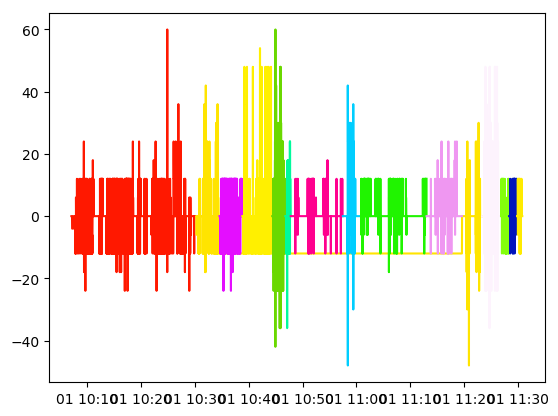

In [414]:

fig, ax = plt.subplots()
for i in big_df.sheet.unique():
    # Bumpers is duplicate
    color=uniqueish_color()
    #ax.plot(big_df[big_df.sheet==i].index, big_df[big_df.sheet==i]['Vertical'], color=color)
    ax.plot(big_df[big_df.sheet==i].index, pd.rolling_median(big_df[big_df.sheet==i]['Vertical'],30), color=color)
plt.show()

In [416]:
big_df.head()

,Vertical,Forward,Radial,Speed,Ignition,file,sheet,cat_id,hard_stop_on,speed_diff,speed_diff_1,speed_ma_100,time_sec
flat_time,,,,,,,,,,,,,
2018-05-01 10:07:01.000000000,0.0,24.0,0.0,1.0,1.0,Acc_Data_Toyota_2604.xlsx,REGULAR DRIVE,0,0,NaN,NaN,NaN,2018-05-01 10:07:00.964000000
2018-05-01 10:07:01.020000000,0.0,36.0,0.0,1.0,1.0,Acc_Data_Toyota_2604.xlsx,REGULAR DRIVE,0,0,0.0,NaN,NaN,2018-05-01 10:07:00.984000256
2018-05-01 10:07:01.040000256,0.0,36.0,0.0,1.0,1.0,Acc_Data_Toyota_2604.xlsx,REGULAR DRIVE,0,0,0.0,0.0,NaN,2018-05-01 10:07:01.004000512
2018-05-01 10:07:01.060000256,0.0,24.0,0.0,1.0,1.0,Acc_Data_Toyota_2604.xlsx,REGULAR DRIVE,0,0,0.0,0.0,NaN,2018-05-01 10:07:01.024000768
2018-05-01 10:07:01.080000256,0.0,24.0,-12.0,1.0,1.0,Acc_Data_Toyota_2604.xlsx,REGULAR DRIVE,0,0,0.0,0.0,NaN,2018-05-01 10:07:01.044001024


In [421]:
research_dfa.keys()

Index(['Vertical', 'Radial', 'Forward', 'Vertical_std', 'Radial_std',
       'Forward_std', 'Vertical_max', 'Radial_max', 'Forward_max',
       'Vertical_min', 'Radial_min', 'Forward_min', 'cat_id', 'hard_stop_on'],
      dtype='object')

In [437]:
big_df['flat_time']=t
big_df['flat_time_sec']=big_df['flat_time'].dt.round('s')

In [441]:
# making the research dfa - second based 
research_dfa=big_df.groupby('flat_time_sec')['Vertical','Radial','Forward'].mean()\
    .join(big_df.groupby('flat_time_sec')['Vertical','Radial','Forward'].std(), rsuffix='_std')\
    .join(big_df.groupby('flat_time_sec')['Vertical','Radial','Forward'].max(), rsuffix='_max')\
    .join(big_df.groupby('flat_time_sec')['Vertical','Radial','Forward'].min(), rsuffix='_min')\
    .join(big_df.groupby('flat_time_sec')['cat_id'].max())\
    .join(big_df.groupby('flat_time_sec')['hard_stop_on'].max())\
     .join(big_df.groupby('flat_time_sec')['sheet'].max())

### some more plots

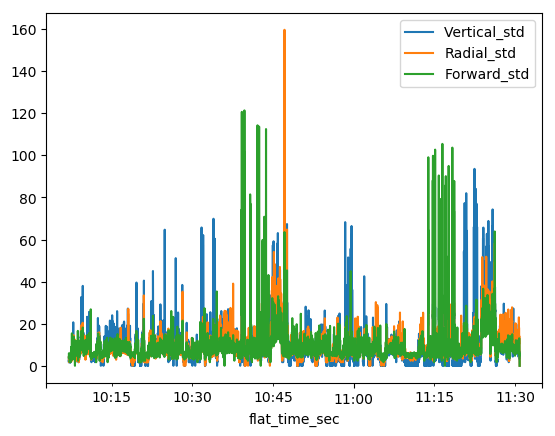

In [439]:
research_dfa[['Vertical_std','Radial_std','Forward_std']].plot()

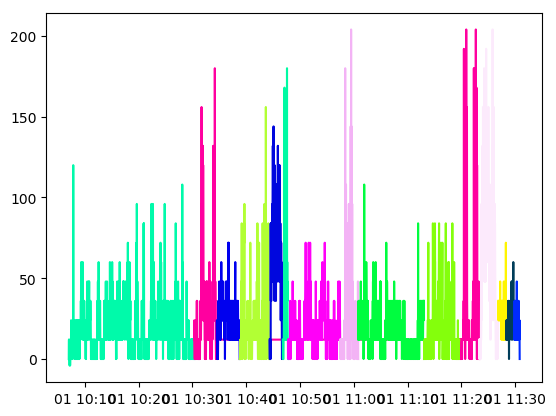

In [450]:
fig, ax = plt.subplots()
for i in big_df.sheet.unique():
    # Bumpers is duplicate
    color=uniqueish_color()
    #ax.plot(big_df[big_df.sheet==i].index, big_df[big_df.sheet==i]['Vertical'], color=color)
    ax.plot(research_dfa[research_dfa.sheet==i].index, \
            research_dfa[research_dfa.sheet==i]['Vertical'], color=color)

plt.show()

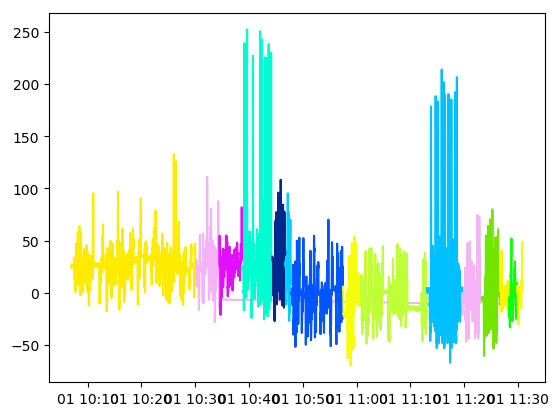

In [449]:
fig, ax = plt.subplots()
for i in big_df.sheet.unique():
    # Bumpers is duplicate
    color=uniqueish_color()
    #ax.plot(big_df[big_df.sheet==i].index, big_df[big_df.sheet==i]['Vertical'], color=color)
    ax.plot(research_dfa[research_dfa.sheet==i].index, \
            research_dfa[research_dfa.sheet==i]['Forward'], color=color)

plt.show()

## More

In [455]:
trn,test = train_test_split(research_dfa)
len(trn), len(test)

(3772, 1258)

In [456]:
len(research_dfa),sum(research_dfa.hard_stop_on==1)

(5030, 115)

In [459]:
research_dfa.keys()

Index(['Vertical', 'Radial', 'Forward', 'Vertical_std', 'Radial_std',
       'Forward_std', 'Vertical_max', 'Radial_max', 'Forward_max',
       'Vertical_min', 'Radial_min', 'Forward_min', 'cat_id', 'hard_stop_on',
       'sheet'],
      dtype='object')

In [460]:
predictive_features=['Vertical', 'Radial', 'Forward', 'Vertical_std', 'Radial_std',\
       'Forward_std', 'Vertical_max', 'Radial_max', 'Forward_max',\
       'Vertical_min', 'Radial_min', 'Forward_min']

In [468]:
models=[LogisticRegression(),svm.SVC(decision_function_shape='ovo')]
for model in models:
    # SVM is much slower
    model.fit(trn[predictive_features],trn['hard_stop_on'])
    print(model.score(test[predictive_features],test[['hard_stop_on']]))

0.9713831478537361
0.9737678855325914


In [470]:
np.max(models[0].predict_proba(test[predictive_features]),axis=0)

array([1.        , 0.73034996])

In [475]:
sum(models[0].predict_proba(test[predictive_features])>0.1)

array([1258,   64])

In [495]:
models[0].predict_proba(test[predictive_features])>0.1

array([[ True, False],
       [ True, False],
       [ True, False],
       ...,
       [ True,  True],
       [ True, False],
       [ True, False]])

In [528]:

cm = confusion_matrix(np.array(models[0].predict_proba(test[predictive_features])>0.1)[:,1], test[['hard_stop_on']])
cm

array([[1175,   19],
       [  50,   14]])

In [530]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)

clf.fit(trn[predictive_features],trn['hard_stop_on'])        

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(5, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [531]:
cm = confusion_matrix(np.array(clf.predict_proba(test[predictive_features])>0.1)[:,1], test[['hard_stop_on']])
cm

array([[1185,   21],
       [  40,   12]])

## Smoothed Z score algo

In [1547]:
import pylab

def thresholding_algo(y, lag, threshold, influence):
    signals = np.zeros(len(y))
    filteredY = np.array(y)
    avgFilter = [0]*len(y)
    stdFilter = [0]*len(y)
    avgFilter[lag - 1] = np.mean(y[0:lag])
    stdFilter[lag - 1] = np.std(y[0:lag])
    for i in range(lag, len(y)):
        if abs(y[i] - avgFilter[i-1]) > threshold * stdFilter [i-1]:
            if y[i] > avgFilter[i-1]:
                signals[i] = 1
            else:
                signals[i] = -1

            filteredY[i] = influence * y[i] + (1 - influence) * filteredY[i-1]
            avgFilter[i] = np.mean(filteredY[(i-lag):i])
            stdFilter[i] = np.std(filteredY[(i-lag):i])
        else:
            signals[i] = 0
            filteredY[i] = y[i]
            avgFilter[i] = np.mean(filteredY[(i-lag):i])
            stdFilter[i] = np.std(filteredY[(i-lag):i])

    return dict(signals = np.asarray(signals), avgFilter = np.asarray(avgFilter), stdFilter = np.asarray(stdFilter))

In [1548]:
big_df[big_df['cat_id'].isin([4,40])][['sheet','file']].drop_duplicates().iloc[0]

sheet                Bumper1
file     Acc_Data_0805 .xlsx
Name: 2018-05-10 11:52:16.607000, dtype: object

In [1609]:
f.keys()

dict_keys(['signals', 'avgFilter', 'stdFilter'])

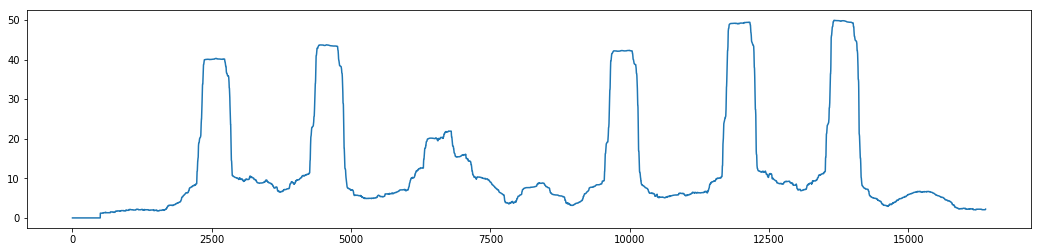

In [1611]:
f=thresholding_algo(df.Vertical,500,10,0)
fig,ax = plt.subplots(figsize=(18,4))
ax.plot(f['stdFilter'])


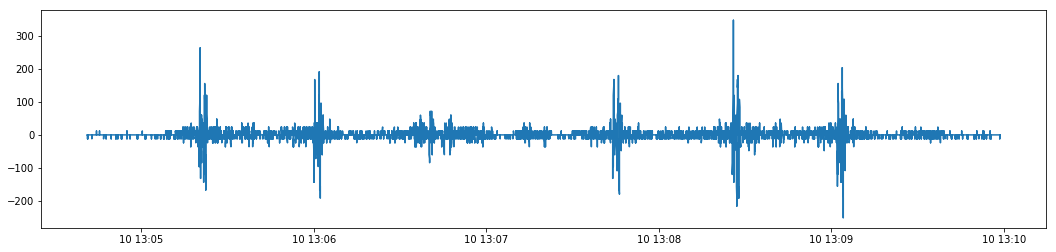

In [1596]:
fig,ax = plt.subplots(figsize=(18,4))
plt.plot(df.index, df['Vertical'])